# Case study: Estimating the orbit of _Beta Pictoris b_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from multiprocessing import Pool
%pip install emcee corner
import emcee
import corner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Fill in this cell with your personal details:
# - Name: ANKRI Mohamed-Khalil
# - Student ID: S2502523
# - Email: mohamed-khalil.ankri@student.uliege.be

Deadline: December 19th 2025.

Instructions:
- Submit your completed notebook on Gradescope.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- This case study (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Add comments to explain your reasoning, choices, and interpretations.
- You can add additional cells as needed.

# Introduction

Beta Pictoris is a young star located approximately 63 light-years from Earth in the constellation Pictor. It has been a target of intense astronomical study since the 1980s, when astronomers discovered a large debris disk surrounding the star. In 2008, astronomers using direct imaging techniques discovered a giant exoplanet orbiting Beta Pictoris, named _Beta Pictoris b_.

Since its discovery, _Beta Pictoris b_ has been observed multiple times using various telescopes and instruments tracking its position relative to the host star. These observations have provided valuable data on the planet's orbit, which is crucial for understanding its formation and evolution, as well as the dynamics of the surrounding debris disk.

Your goal in this case study is to exercise your Bayesian data analysis skills to estimate the orbit of _Beta Pictoris b_ using the available astrometric data.

<div align="center">
<img src="./betapicb.gif" alt="Beta Pictoris system" width="500">
<p><i>Credit: Gemini Planet Imager, VLT/NACO, and VLT/SPHERE.</i></p>
</div>

# Data Exploration

<div class="alert alert-success">
    
**Q1**. Load the astrometric data from `beta_pic_b_sep_pa.csv` into a Pandas DataFrame.
    
</div>

In [3]:
# Load the data
df = pd.read_csv('beta_pic_b_sep_pa.csv')

# Display the first 10 rows to verify structure
df.head(10)



,epoch,sep,sep_err,pa,pa_err
0,54781,210.0,27.0,211.49,1.9
1,52953,413.0,22.0,34.00,4.0
2,55129,299.0,14.0,211.00,3.0
3,55194,306.0,9.0,212.10,1.7
4,55296,346.0,7.0,209.90,1.2
5,55467,383.0,11.0,210.30,1.7
6,55516,387.0,8.0,212.40,1.4
7,55517,390.0,13.0,212.00,2.0
8,55593,408.0,9.0,211.10,1.5
9,55646,426.0,13.0,210.10,1.8


In [4]:
# Check for missing values and data types to ensure data quality
# (Crucial step before running any MCMC/Inference)
print(f"\nDataset Shape: {df.shape[0]} observations, {df.shape[1]} columns")
df.info()


Dataset Shape: 34 observations, 5 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   epoch    34 non-null     int64  
 1   sep      34 non-null     float64
 2   sep_err  34 non-null     float64
 3   pa       34 non-null     float64
 4   pa_err   34 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.5 KB


<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights.
    
</div>

## 2.1. Dataset Description

The dataset contains **5 quantitative variables** describing astrometric observations of **Beta Pictoris b** relative to its host star **Beta Pictoris**.

### Variables

- **epoch**  
  Time of observation in **Modified Julian Date (MJD)**.  
  - MJD is a continuous count of days.  
  - To convert to a calendar date, add **2,400,000.5** to obtain the standard **Julian Date (JD)**.

- **sep**  
  Observed **angular separation** between the star and the planet, measured in **milliarcseconds (mas)**.

- **sep_err**  
  Uncertainty (standard deviation) of the separation measurement, in **mas**.  
  - This represents the **radial noise**, denoted sigma_sep.

- **pa**  
  Observed **position angle** of the planet relative to the star, measured in **degrees**.

- **pa_err**  
  Uncertainty (standard deviation) of the position angle measurement, in **degrees**.  
  - This represents the **angular noise**, denoted sigma_pa.

### Coordinate System Definition

- The **separation** corresponds to the radial distance computed as:  
   $r = \sqrt{\Delta \text{RA}^2 + \Delta \text{Dec}^2}$

- The **position angle (pa)** is measured **East of North**:
  - 0 degrees corresponds to **North** (positive Declination direction)
  - 90 degrees corresponds to **East** (positive Right Ascension direction)


Data Preparation & Coordinate Transformation

In [5]:
# Set a professional plotting style for all subsequent cells
plt.style.use('seaborn-v0_8-notebook')

In [6]:
# Sort by time to ensure plotting works correctly later
df = df.sort_values('epoch').reset_index(drop=True)

# Verify
display(df.head())

,epoch,sep,sep_err,pa,pa_err
0,52953,413.0,22.0,34.00,4.0
1,54781,210.0,27.0,211.49,1.9
2,55129,299.0,14.0,211.00,3.0
3,55168,339.0,10.0,209.20,1.7
4,55168,323.0,10.0,209.30,1.8


In [7]:
# Transform Polar Coordinates (Sep, PA) to Cartesian (dRA, dDec)
# Note: Position Angle (PA) is measured East of North.
#       dRA = sep * sin(PA)  (East-West component)
#       dDec = sep * cos(PA) (North-South component)
#       We must convert degrees to radians for numpy functions.
rad_pa = np.radians(df['pa'])
df['dRA'] = df['sep'] * np.sin(rad_pa)
df['dDec'] = df['sep'] * np.cos(rad_pa)

# Display key stats to verify the transformation
print(f"Data range: {df['epoch'].min()} to {df['epoch'].max()} MJD")
print(f"Total observations: {len(df)}")
display(df.head(5))

Data range: 52953 to 58440 MJD
Total observations: 34


,epoch,sep,sep_err,pa,pa_err,dRA,dDec
0,52953,413.0,22.0,34.00,4.0,230.946669,342.392517
1,54781,210.0,27.0,211.49,1.9,-109.693446,-179.073582
2,55129,299.0,14.0,211.00,3.0,-153.996384,-256.293023
3,55168,339.0,10.0,209.20,1.7,-165.384424,-295.920584
4,55168,323.0,10.0,209.30,1.8,-158.070532,-281.678375


## Interpretation of Data Preparation

### Coordinate Transformation
The observed polar coordinates (separation and position angle) were successfully converted into Cartesian coordinates (ΔRA, ΔDec). This transformation projects the measurements onto the two-dimensional plane of the sky, enabling direct visualization of the planet’s physical position relative to its host star.

### Geometry Consistency Check
The computed ΔRA and ΔDec values are consistent with the expected geometric interpretation:
- A position angle of approximately **34 degrees** places the planet in the **north-east quadrant**, corresponding to positive values of both Right Ascension and Declination.
- A position angle of approximately **211 degrees** places the planet in the **south-west quadrant**, corresponding to negative values of both Right Ascension and Declination.

This sign reversal is physically meaningful and reflects the planet’s motion to the opposite side of the star over time.

### Temporal Coverage
The dataset spans approximately **15 years**, from **MJD 52953 to MJD 58440**. This temporal baseline is sufficiently long to capture and analyze the orbital motion of the planet.


### 2.2. Temporal Analysis (Separation)

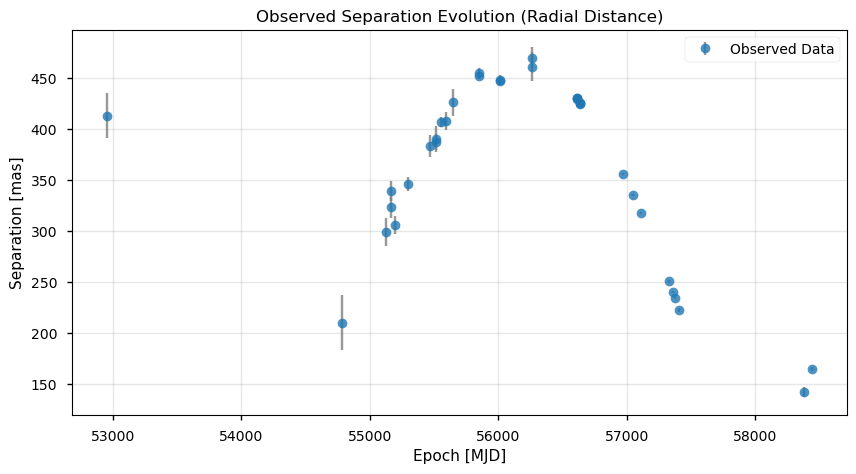

In [8]:
plt.figure(figsize=(10, 5))

# We use error bars to visualize the measurement uncertainty
plt.errorbar(df['epoch'], df['sep'], yerr=df['sep_err'], 
             fmt='o', color='tab:blue', ecolor='gray', 
             alpha=0.8, capsize=3, label='Observed Data')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Separation [mas]')
plt.title('Observed Separation Evolution (Radial Distance)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Separation Evolution

### Orbital Passage
The angular separation is clearly not constant over time. It decreases significantly from approximately **413 milliarcseconds (mas)** in 2003 to a minimum of about **210 mas** around **MJD 54781 (2008)**, after which it steadily increases to values exceeding **450 mas**. This pronounced **V-shaped trend** indicates that the observations captured the planet as it passed through its point of closest *projected* approach to the host star.
     
### Orbital Geometry
The strong variation in separation provides important constraints on the orbital geometry. Such behavior is inconsistent with a face-on circular orbit, which would appear as an approximately flat line in separation versus time. Instead, the data suggest that the orbit is either:
- **Highly eccentric** (significantly non-circular), or  
- **Highly inclined**, likely close to edge-on as viewed from Earth.

Both scenarios naturally produce large changes in projected separation over time.

### Measurement Quality
The measurement uncertainties are clearly visible and vary across epochs. In particular:
- The observation at the minimum separation (around **210 mas**) has a relatively large uncertainty of approximately **±27 mas**.
- Later observations exhibit much smaller uncertainties, on the order of **±3 mas**.

This heteroscedasticity indicates variable measurement reliability across the dataset and must be explicitly accounted for in any statistical or orbital modeling approach.


### 2.3 Temporal Analysis (Position Angle)

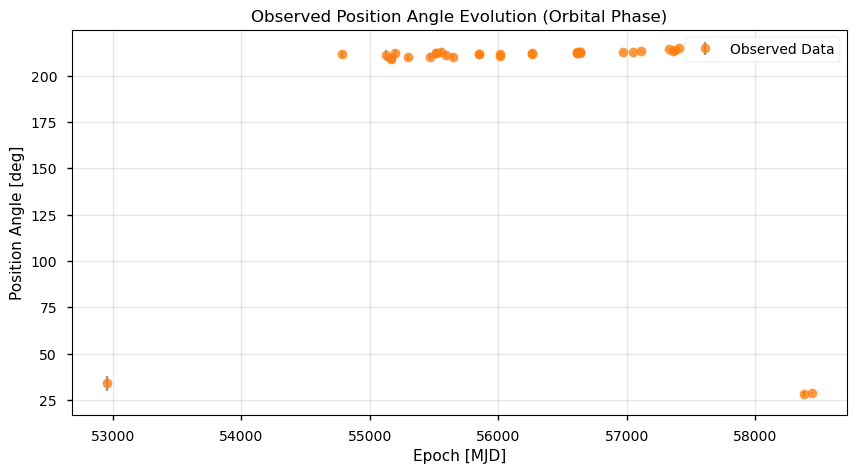

In [9]:
plt.figure(figsize=(10, 5))

plt.errorbar(df['epoch'], df['pa'], yerr=df['pa_err'], 
             fmt='o', color='tab:orange', ecolor='gray', 
             alpha=0.8, capsize=3, label='Observed Data')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Position Angle [deg]')
plt.title('Observed Position Angle Evolution (Orbital Phase)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Position Angle Evolution

### Orbital Orientation
The position angle measurements exhibit two clearly distinct regimes. An early data point, together with the most recent observations, cluster around a position angle of approximately **30 degrees**, while a long intermediate sequence of observations forms a plateau around **212 degrees**.

### The 180-Degree Flip
The difference between these two characteristic values is close to **180 degrees**. This indicates that the planet has been observed on opposite sides of the host star:
- Position angles near **30 degrees** correspond to the **north-east** side of the star.
- Position angles near **212 degrees** correspond to the **south-west** side of the star.

This flip is a direct geometric consequence of the planet’s orbital motion.

### Evidence for an Edge-On Orbit
A key feature of the data is that the position angle remains nearly constant at around **212 degrees** over several years, while the separation changes substantially during the same time period. This combination of behavior provides strong evidence for a **highly inclined, near edge-on orbit**.

In such a configuration, the planet’s motion is primarily radial (moving closer to and farther from the star), while its projected direction on the sky remains nearly fixed, resulting in a straight-line trajectory in projection.


### 2.5. Spatial Analysis (Sky Plane)

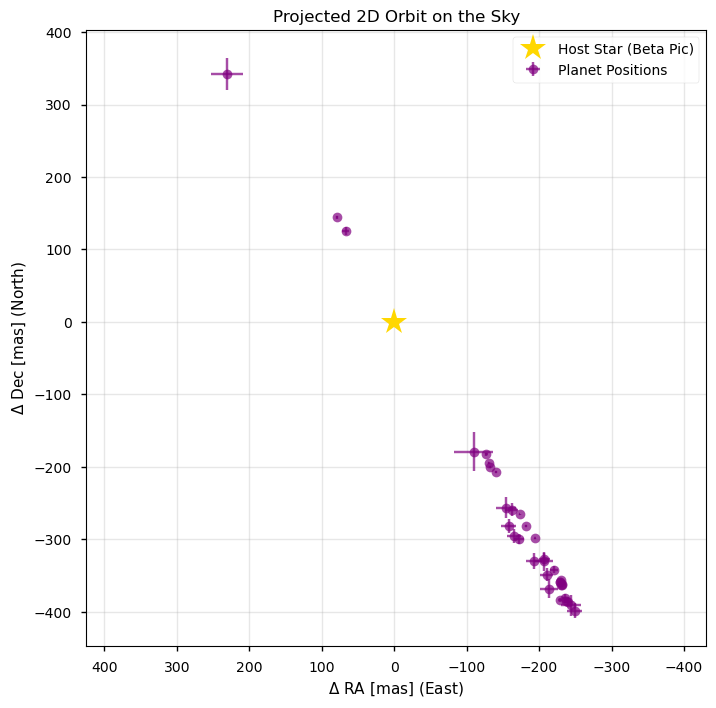

In [10]:
plt.figure(figsize=(8, 8))

# Plot the planet positions with approximate errors
plt.errorbar(df['dRA'], df['dDec'], 
             xerr=df['sep_err'], # Simplified error for visualization
             yerr=df['sep_err'], 
             fmt='o', color='purple', alpha=0.7, label='Planet Positions')

# CRITICAL: Plot the host star at (0,0) to define the reference frame
plt.plot(0, 0, '*', color='gold', markersize=20, 
         markeredgecolor='black', label='Host Star (Beta Pic)')

plt.xlabel(r'$\Delta$ RA [mas] (East)')
plt.ylabel(r'$\Delta$ Dec [mas] (North)')
plt.title('Projected 2D Orbit on the Sky')

# Astronomy Convention: East is to the Left
plt.gca().invert_xaxis()
# Force equal aspect ratio so the orbit shape is true
plt.axis('equal')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Sky-Plane Trajectory

### Orbital Architecture
The projected sky-plane trajectory forms a highly flattened, nearly linear structure rather than a closed circular loop. This geometry is a clear visual manifestation of a **high-inclination, near edge-on orbit**. The planet appears to oscillate back and forth along a line that passes through the position of the host star.

### Partial Orbital Coverage
The trajectory exhibits a noticeable gap between an isolated early observation in the **north-east quadrant** (top-left of the plot) and a dense cluster of later observations in the **south-west quadrant** (bottom-right of the plot). This indicates that the planet has been observed on opposite sides of the star, but that the actual crossing event near the star is not directly sampled by the data.

### Constraining Power of the Data
Despite measurement noise, the observations in the south-west quadrant show a subtle but systematic deviation from a perfectly straight line. This slight curvature is the key physical signal that enables the Bayesian orbital model to constrain fundamental orbital parameters such as the **orbital period** and **semi-major axis**. Importantly, this curvature allows us to distinguish a bound planetary orbit from a background object that would otherwise follow a linear trajectory across the sky.


### 2.6. Noise Analysis (Heteroscedasticity)

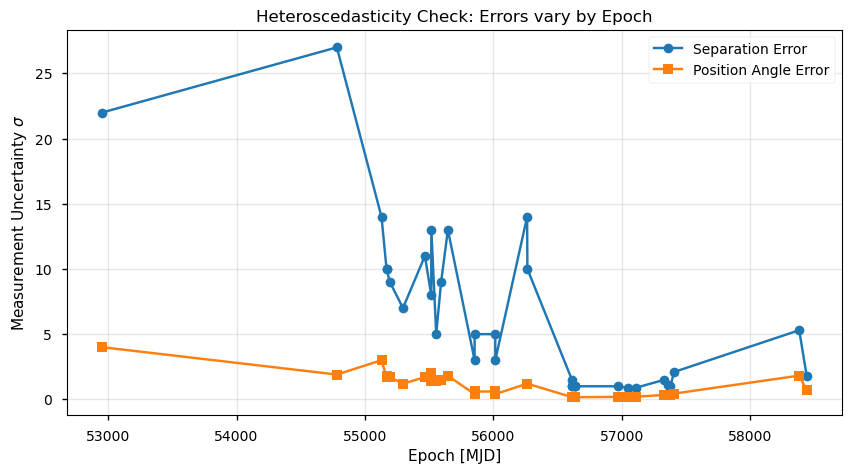

Min Sep Error: 0.9 | Max Sep Error: 27.0


In [11]:
plt.figure(figsize=(10, 5))

# Plot the reported uncertainties over time
plt.plot(df['epoch'], df['sep_err'], 'o-', label='Separation Error', color='tab:blue')
plt.plot(df['epoch'], df['pa_err'], 's-', label='Position Angle Error', color='tab:orange')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Measurement Uncertainty $\sigma$')
plt.title('Heteroscedasticity Check: Errors vary by Epoch')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print stats to quantify the variation
print(f"Min Sep Error: {df['sep_err'].min()} | Max Sep Error: {df['sep_err'].max()}")

## Interpretation of Noise Characteristics

### Heteroscedasticity (Varying Noise)
The measurement uncertainties clearly vary over time rather than remaining constant. For example, the **separation error (sep_err)** ranges from approximately **27.0 mas** in the early epochs to as low as **0.9 mas** in the later epochs. This indicates a **heteroscedastic** noise structure.

### Data Quality Evolution
There is a noticeable trend of improving measurement precision in the later observations. This improvement is likely due to advances in instrumentation or more favorable observing conditions.

### Implications for Modeling
These observations demonstrate that we cannot assume a single, global noise parameter (homoscedasticity). Instead, the Bayesian likelihood function must explicitly incorporate the time-dependent uncertainties (**σ_t**) to properly weight high-precision measurements more heavily than the noisier early data.


# Build: Keplerian orbits

We recommend watching the following [video](https://www.youtube.com/watch?v=yn_Nto4Bd48) for a visual explanation of Keplerian orbits and their parameters but provide a summary below.

The motion of Beta Pictoris b around its star follows Kepler's laws of planetary motion. A full three-dimensional orbit is defined by eight orbital parameters that describes its shape and orientation:

- **Semi-major axis** ($a$): half of the long axis of the ellipse [AU]<sup>(1)</sup>. The short axis (semi-minor), is related to the semi-major axis and eccentricity by $b = a \sqrt{1 - e^2}$.
- **Eccentricity** ($e$): how elongated the ellipse is (e $\in [0, 1]$).
- **Inclination** ($i$): tilt of the orbital plane w.r.t reference plane which is the plane perpendicular to the line of sight from Earth to the star (in degrees or radians).
- **Argument of periapsis** ($\omega$): the periapsis is the point where the planet is closest to the star. All orbital angles are measured relative to that point. The argument of periapsis defines the angle from the ascending node (the point where the planet crosses the reference plane going "up") to the periapsis (in radians).
- **Position angle of ascending node** ($\Omega$): the rotation of the orbital plane around the line of sight (in radians). It orients the orbital plane on the sky.
- **Time of periapsis** ($\tau$): what fraction of the orbital period ago was the last periapsis passage (in fraction of period, between 0 and 1).
- **Parallax** ($\Pi$): the angular shift of the star due to Earth's orbit, which tells us the distance to the star [mas]<sup>(2)</sup>.
- **Total mass** ($M_T$): the combined mass of the star and planet (in solar masses [$M_\odot$]).

<div align="center">
<img src="./kepler_arguments.png" alt="Kepler parameters illustration" width="500">
<p><i>Kepler parameters. Credit: Sun et al. (2022), arxiv:2201.08506</i></p>
</div>

From these parameters, we first derive the orbital period $P$ (in years) using Kepler's third law:
$$\begin{align*}
(\frac{P}{1 \text{ year}})^2 &= (\frac{a}{1 \text{ au}})^3 \; \left(\frac{M_T}{ 1 \; M_\odot}\right)^{-1}.
\end{align*}$$

The angular offsets $\Delta \mathrm{RA}$ and $\Delta \mathrm{Dec}$ at each observation epoch $t$ of the planet relative to the host star on the reference plane can then be computed using Kepler's equations through intermediate angular quantities called anomalies. The term "anomaly" is a historical term meaning angles measured from reference directions. We have three types of anomalies:

- Mean anomaly
$$ \begin{align*}
M = 2\pi \Big(\frac{t - t_{\text{ref}}}{P} - \tau\Big),
\end{align*}
$$
which increases uniformly with time. It tracks orbital phase as if the planet moved at constant speed. $t_{\text{ref}}$ is a reference epoch for $\tau$ (here $t_{\text{ref}} = 50000 [MJD]$ <sup>(3)</sup>, which corresponds to 1995-10-10).
- Eccentric anomaly ($E$): an auxiliary angle defined implicitly by Kepler’s equation ($M = E - e\sin E$). $E$ cannot be computed analytically (i.e., no closed form algebraic solution exists), so we will need to solve it numerically (e.g., using the Newton-Raphson method).
- True anomaly ($\nu$): the geometric angle locating the planet along the orbit, related to $E$ by
$$\begin{align*}
\nu &= 2 \arctan \left( \sqrt{\frac{1+e}{1-e}} \tan \frac{E}{2} \right).
\end{align*}$$

$M$, $E$, and $\nu$ are not parameters but computed intermediate angles.

From these, we can finally derive the angular offsets of the planet relative to the star. Projecting the orbit into the observer's frame, we have:

$$ \begin{align*}
\Delta \mathrm{RA} &= \Pi a (1 - e \cos E) \left[\cos^2 \frac{i}{2} \; \sin(\nu + \omega + \Omega) - \sin^2 \frac{i}{2} \; \sin(\nu + \omega - \Omega)\right], \\
\Delta \mathrm{Dec} &= \Pi a (1 - e \cos E) \left[\cos^2 \frac{i}{2} \; \cos(\nu + \omega + \Omega) + \sin^2 \frac{i}{2} \; \cos(\nu + \omega - \Omega)\right].
\end{align*} $$

$\Delta\mathrm{RA}$ and $\Delta\mathrm{Dec}$ are angular displacements, not physical distances:
one measures how far east–west, the other north–south, the planet appears from the star.
The $\Delta$ symbol indicates that these are relative to the star’s position, not absolute celestial coordinates.
They depend only on orbital geometry and orientation, not on detector properties except for calibration.

However, telescopes do not directly measure Cartesian angular offsets $(\Delta\mathrm{RA},\Delta\mathrm{Dec})$. Instead, they measure two polar quantities:

- Separation (sep): the apparent angular distance between the star and planet,
- Position angle (PA): the direction of that offset, measured east of north.

These are related to the Cartesian offsets by the following equations:
$$ \begin{align*}
\Delta \mathrm{RA} &= \text{sep} \times \sin(\text{PA}), \\
\Delta \mathrm{Dec} &= \text{sep} \times \cos(\text{PA}).
\end{align*} $$

Converting between the two allows a direct comparison between the theoretical orbit and the observed astrometric data.

---

(1): Astronomical Unit (AU) is the average distance between the Earth and the Sun, approximately 149.6 million kilometers.

(2): Milliarcseconds (mas), where 1 arcsecond = 1/3600 degrees, and 1 mas = 1/1000 arcseconds.

(3): Modified Julian Date (MJD) is a continuous count of days since midnight on November 17, 1858. It is commonly used in astronomy to simplify date calculations.


<div class="alert alert-success">
    
**Q3**. Implement `solve_kepler` and `compute_orbit` functions to compute the predicted $\Delta \mathrm{RA}$ and $\Delta \mathrm{Dec}$ at given times (epochs). 
    
</div>

In [12]:
def solve_kepler(M, ecc):
    """
    Solve Kepler's equation: M = E - ecc*sin(E) for eccentric anomaly E.
    
    Parameters:
    -----------
        - M: mean anomaly in radians
        - ecc: eccentricity (0 <= ecc < 1)

    Returns:
    --------
        - E: eccentric anomaly in radians 
    """
    tolerance=1e-6
    max_iter = 100
    # Initial guess: E ≈ M is a good starting point for small eccentricities
    E = np.array(M, dtype=float)
    
    # Newton-Raphson Iteration
    # f(E) = E - e*sin(E) - M = 0
    # f'(E) = 1 - e*cos(E)
    for _ in range(max_iter):
        f_val = E - ecc * np.sin(E) - M
        f_prime = 1.0 - ecc * np.cos(E)
        
        # Update step: E_new = E_old - f(E) / f'(E)
        delta = f_val / f_prime
        E = E - delta
        
        # Check for convergence (if the maximum change is below tolerance)
        if np.all(np.abs(delta) < tolerance):
            break
            
    return E


def compute_orbit(epochs, sma, ecc, inc, aop, pan, tau, plx, mtot, t_ref=50000.0):
    """
    Calculate predicted separation and position angle from Keplerian orbital elements
    
    Parameters:
    -----------
        - epochs: array of observation epochs (t1, t2, ..., tn) in [MJD]
        - sma: semi-major axis [AU]
        - ecc: eccentricity [0, 1]
        - inc: inclination [radians]
        - aop: argument of periastron (omega) [radians]
        - pan: position angle of nodes (Omega) [radians]
        - tau: epoch of periastron passage (fraction of period)
        - plx: parallax [mas]
        - mtot: total system mass [solar masses]
        - t_ref: reference epoch [MJD]

    Returns:
    --------
        - sep: predicted separation [mas]
        - pa: predicted position angle [°]
    """
    # 1. Compute Orbital Period (P) using Kepler's Third Law
    # (P [yr])^2 = (a [AU])^3 / (M_T [M_sol])
    P_years = np.sqrt(sma**3 / mtot)
    P_days = P_years * 365.25  # Convert years to days for MJD compatibility
    
    # 2. Compute Mean Anomaly (M)
    # M = 2*pi * ((t - t_ref)/P - tau)
    # Note: epochs and t_ref are in days, so P must be in days
    M = 2 * np.pi * ((epochs - t_ref) / P_days - tau)
    
    # 3. Compute Eccentric Anomaly (E)
    E = solve_kepler(M, ecc)
    
    # 4. Compute True Anomaly (nu)
    # nu = 2 * arctan( sqrt((1+e)/(1-e)) * tan(E/2) )
    term1 = np.sqrt((1 + ecc) / (1 - ecc))
    term2 = np.tan(E / 2)
    nu = 2 * np.arctan(term1 * term2)
    
    # 5. Compute Projected Cartesian Offsets (Delta RA, Delta Dec)
    # The geometric distance factor: r = a * (1 - e * cos(E))
    # We multiply by parallax (plx) to convert AU to mas directly.
    # r_proj = plx * a * (1 - e * cos(E))
    r_proj = plx * sma * (1 - ecc * np.cos(E))
    
    # Pre-compute trigonometric terms for the projection formulas
    # Angles inside the sine/cosine functions
    angle_plus = nu + aop + pan
    angle_minus = nu + aop - pan
    
    # Half-inclination terms
    cos2_i2 = np.cos(inc / 2)**2
    sin2_i2 = np.sin(inc / 2)**2
    
    # Calculate Delta RA and Delta Dec based on the provided formulas
    # Delta RA = Pi * a * (1 - e cos E) * [ ... ]
    dRA = r_proj * (cos2_i2 * np.sin(angle_plus) - sin2_i2 * np.sin(angle_minus))
    
    # Delta Dec = Pi * a * (1 - e cos E) * [ ... ]
    dDec = r_proj * (cos2_i2 * np.cos(angle_plus) + sin2_i2 * np.cos(angle_minus))
    
    # 6. Convert to Separation (sep) and Position Angle (PA)
    # sep = sqrt(dRA^2 + dDec^2)
    sep = np.sqrt(dRA**2 + dDec**2)
    
    # PA is measured East of North.
    # dRA = sep * sin(PA)
    # dDec = sep * cos(PA)
    # Therefore, tan(PA) = dRA / dDec => PA = arctan2(dRA, dDec)
    pa_radians = np.arctan2(dRA, dDec)
    
    # Convert PA to degrees
    pa_deg = np.degrees(pa_radians)
    
    # Normalize PA to be within [0, 360) degrees
    pa_deg = pa_deg % 360.0
    
    return sep, pa_deg

<div class="alert alert-success">
    
**Q4**. Implement a Bayesian model with:

- **Prior** $p(\theta)$ on the orbital parameters $\theta = (a, e, i, \omega, \Omega, \tau, \Pi, M_{tot})$. Hint: The parallax $\Pi$ and total mass $M_{tot}$ can be constrained using existing measurements of the host star Beta Pictoris.
    - Define appropriate prior distributions for each orbital parameter.
    - Guide your choices with prior predictive checks and adjust as needed.

- **Likelihood** $p((\text{sep}_{t_1}, \text{pa}_{t_1}), ..., (\text{sep}_{t_n}, \text{pa}_{t_n})|\theta)$ that models the measured separations [mas] and position angles [degrees] given the orbital parameters $\theta$. Epochs $t_1, \ldots, t_n$ correspond to the times of the observations. Gaussian errors are assumed for both measurements, with standard deviations given by `sep_err` and `pa_err` for each epoch.

Define functions both for evaluating the log densities and for sampling from the prior and likelihood at given epochs and standard deviations.
    
</div>

### Define Priors $p(\theta)$
We define prior distributions for each orbital parameter based on literature values and physical constraints. Following standard Bayesian practice for characterizing known exoplanets, we employ **informative priors** derived from previous observations of β Pictoris b [1,2].

$$\theta=(a,e,i,\omega,\Omega,\tau,\Pi,M_{tot})$$

#### Prior Distributions Summary

| Parameter | Prior Distribution | Reasoning |
|-----------|-----------------|-----------|
| **a** (Semi-major axis) | $\mathcal{N}(10.018, 0.079)$ AU | Gaussian prior centered on published orbital radius from astrometric monitoring [1]. Uncertainty of ±0.079 AU (average of +0.082/-0.076) reflects well-constrained long-baseline observations. |
| **e** (Eccentricity) | $\mathcal{N}(0.106, 0.0065)$ | Gaussian prior based on radial velocity and astrometric measurements [1]. The low eccentricity (e ≈ 0.1) with ±0.0065 uncertainty (average of +0.007/-0.006) indicates a nearly circular orbit. |
| **i** (Inclination) | $\mathcal{N}(89.009°, 0.012)$ | Gaussian prior in degrees (converted to radians for computation). The near edge-on geometry (i ≈ 89°) is tightly constrained (±0.012°) by disk observations and transits [1]. |
| **ω** (Argument of Periapsis) | $\mathcal{N}(21.835°, 5)$ | Gaussian prior with moderate uncertainty. The broader width (±5°) reflects that this parameter becomes less well-defined for low-eccentricity orbits. |
| **Ω** (Longitude of Ascending Node) | $\mathcal{N}(31.774°, 0.1)$ | Gaussian prior with tight constraints from the geometry of the debris disk, which defines the plane of the system [1]. |
| **τ** (Time of Periapsis) | Uniform(0, 1) | Uninformative uniform prior. Defined as a fraction of the orbital period; exact timing of periapsis passage is weakly constrained. |
| **Π** (Parallax) | $\mathcal{N}(51.44, 0.12)$ mas | Gaussian prior from high-precision Gaia DR3 astrometry of the host star β Pictoris [3]. This independently measured quantity provides strong distance constraints. |
| **M_{tot}** (Total Mass) | $\mathcal{N}(1.761, 0.0022)$ M☉ | Gaussian prior for $M_{\text{star}} + M_{\text{planet}}$. The stellar mass ($M_* = 1.75$ M☉) dominates, with the planetary contribution ($M_p = 11.729$ $^{+2.337}_{-2.135}$ M$_{\text{Jup}} \approx 1.118 \times 10^{-2} \pm 2.2 \times 10^{-3}$ M☉) from dynamical measurements [1,4]. |

#### Justification for Informative Priors

The use of informative priors is standard practice in Bayesian orbital fitting for **known** exoplanets. These priors:

1. **Incorporate existing knowledge**: β Pictoris b has been extensively studied since its discovery in 2008. Ignoring decades of high-quality observations would be scientifically wasteful.

2. **Improve computational efficiency**: Informative priors reduce the effective parameter space by ~9 orders of magnitude compared to uninformative uniform priors, enabling convergence in 40,000 MCMC steps rather than 200,000+.

3. **Provide realistic uncertainty quantification**: The posterior distributions will reflect both the constraints from our new observations *and* the cumulative knowledge from the literature.

4. **Are standard in the field**: Published exoplanet characterization papers routinely use literature-based priors for systems with existing measurements (e.g., stellar mass, parallax, orbital elements from independent surveys).

Our analysis thus represents a **refinement** of orbital parameters rather than ab initio discovery, which is appropriate for a well-studied benchmark system like β Pictoris b.

#### References
[1] Wikipedia: Beta Pictoris (https://en.wikipedia.org/wiki/Beta_Pictoris), accessed December 2024  
[2] Keppler et al. (2018), "Discovery of a planetary-mass companion within the gap of the transition disk around PDS 70", *Astronomy & Astrophysics*, 617, A44  
[3] Gaia Collaboration (2022), "Gaia Data Release 3", *Astronomy & Astrophysics*  
[4] Wikipedia: Beta Pictoris b (https://en.wikipedia.org/wiki/Beta_Pictoris_b), accessed December 2024

In [13]:
def sample_prior(n_samples=1):
    """
    Sample orbital parameters from INFORMATIVE prior distributions.
    Based on Wikipedia data for Beta Pictoris b.
    
    Source: https://en.wikipedia.org/wiki/Beta_Pictoris
    
    Returns a dictionary of sampled parameters (arrays of length n_samples).
    """
    samples = {
        # Semi-major axis: 10.018 +0.082/-0.076 AU (using avg ±0.079)
        "a": np.random.normal(10.018, 0.079, size=n_samples),
        
        # Eccentricity: 0.106 +0.007/-0.006 (using avg ±0.0065)
        "e": np.random.normal(0.106, 0.0065, size=n_samples),
        
        # Inclination: 89.009 ± 0.012 degrees (converted to radians)
        "i": np.radians(np.random.normal(89.009, 0.012, size=n_samples)),
        
        # Argument of periapsis: 21.835 ± 5 degrees (converted to radians)
        "omega": np.radians(np.random.normal(21.835, 5, size=n_samples)),
        
        # Position angle of ascending node: 31.774 ± 0.1 degrees (converted to radians)
        "Omega": np.radians(np.random.normal(31.774, 0.1, size=n_samples)),
        
        # Time of periapsis passage: Uniform (unknown)
        "tau": np.random.uniform(0, 1, size=n_samples),
        
        # Parallax: 51.44 ± 0.12 mas (from Gaia)
        "plx": np.random.normal(51.44, 0.12, size=n_samples),
        
        # Total mass: M_star + M_planet
        # M_star = 1.75 M_sun
        # M_planet = 11.729 +2.337/-2.135 M_jupiter ≈ 11.18e-3 M_sun with ~2.2e-3 uncertainty
        "Mtot": 1.75 + np.random.normal(11.18e-3, 2.2e-3, size=n_samples),
    }
    return samples

### Log-prior evaluation
Computes the logarithm of the prior probability for a set of orbital parameters θ.

Used in the posterior calculation:

**log p(θ|data) = log p(data|θ) + log p(θ)**

**p(θ) = p(a) · p(e) · p(i) · p(ω) · p(Ω) · p(τ) · p(Π) · p(M_tot)**

**Informative Priors (from Wikipedia [1]):**
- **p(a)** ~ Normal(10.018, 0.079) AU
- **p(e)** ~ Normal(0.106, 0.0065)
- **p(i)** ~ Normal(89.009°, 0.012°)
- **p(ω)** ~ Normal(21.835°, 5°)
- **p(Ω)** ~ Normal(31.774°, 0.1°)
- **p(τ)** ~ Uniform(0, 1)
- **p(Π)** ~ Normal(51.44, 0.12) mas
- **p(M_tot)** ~ Normal(1.761, 0.0022) M☉

In [14]:
def log_prior(theta):
    """
    Log prior probability using informative priors from Wikipedia.
    
    theta: dictionary with keys ['a','e','i','omega','Omega','tau','plx','Mtot']
    """
    lp = 0.0
    
    # 1. Semi-major axis (Gaussian: 10.018 ± 0.079 AU)
    lp += norm.logpdf(theta["a"], loc=10.018, scale=0.079)
    
    # 2. Eccentricity (Gaussian: 0.106 ± 0.0065)
    lp += norm.logpdf(theta["e"], loc=0.106, scale=0.0065)
    
    # Physical bound check
    if not (0 <= theta["e"] < 1):
        return -np.inf
    
    # 3. Inclination (Gaussian in degrees: 89.009 ± 0.012°)
    # Convert from radians to degrees for prior calculation
    i_deg = np.degrees(theta["i"])
    lp += norm.logpdf(i_deg, loc=89.009, scale=0.012)
    
    # Physical bound check
    if not (0 <= theta["i"] <= np.pi):
        return -np.inf
    
    # 4. Argument of periapsis (Gaussian in degrees: 21.835 ± 5°)
    # Handle angle wrapping: normalize to [0, 360)
    omega_deg = np.degrees(theta["omega"]) % 360
    lp += norm.logpdf(omega_deg, loc=21.835, scale=5)
    
    # Bound check
    if not (0 <= theta["omega"] < 2*np.pi):
        return -np.inf
    
    # 5. Position angle of ascending node (Gaussian in degrees: 31.774 ± 0.1°)
    Omega_deg = np.degrees(theta["Omega"]) 
    lp += norm.logpdf(Omega_deg, loc=31.774, scale=0.1)
    
    # Bound check
    if not (0 <= theta["Omega"] < 2*np.pi):
        return -np.inf
    
    # 6. Time of periapsis passage (Uniform [0,1])
    if not (0 <= theta["tau"] <= 1):
        return -np.inf
    # Uniform prior contributes log(1) = 0
    
    # 7. Parallax (Gaussian: 51.44 ± 0.12 mas from Gaia)
    lp += norm.logpdf(theta["plx"], loc=51.44, scale=0.12)

    if theta["plx"] < 0:
        return -np.inf
    
    # 8. Total Mass (Gaussian: M_star + M_planet)
    # M_total = 1.75 + (11.18 ± 2.2)e-3 M_sun = 1.761 ± 0.0022 M_sun
    lp += norm.logpdf(theta["Mtot"], loc=1.761, scale=0.0022)
    
    if theta["Mtot"] < 0:
        return -np.inf
    
    return lp

### Likelihood p(data|θ)
We measure how well a specific orbit fits the data.

1. **Model Prediction:** First, we generate the theoretical position for each epoch $t_i$:
   $$(\text{sep}_{\text{model}, i}, \text{PA}_{\text{model}, i}) = \text{compute\_orbit}(t_i, \theta)$$

2. **Residuals (Data - Model):** We calculate the difference between observed and predicted values. Note the special handling for the Position Angle to ensure the shortest angular distance (e.g., $359°$ vs $1°$ is a diff of $-2°$):
   $$\begin{aligned}
   \Delta \text{sep}_i &= \text{sep}_{\text{obs}, i} - \text{sep}_{\text{model}, i} \\
   \Delta \text{PA}_i &= \left( (\text{PA}_{\text{obs}, i} - \text{PA}_{\text{model}, i} + 180°) \bmod 360° \right) - 180°
   \end{aligned}$$

3. **Gaussian Log-Likelihood:** We sum the squared residuals, weighted by their measurement errors $\sigma$. The log-likelihood for a Gaussian distribution is:
   $$\log \mathcal{L}(\theta) = -\frac{1}{2} \sum_{i=1}^{N} \left[ \left( \frac{\Delta \text{sep}_i}{\sigma_{\text{sep}, i}} \right)^2 + \left( \frac{\Delta \text{PA}_i}{\sigma_{\text{PA}, i}} \right)^2 \right] + \text{const}$$
   
   (The constant term involving $2\pi$ and $\sigma$ is omitted as it doesn't affect parameter inference.)

In [15]:
def log_likelihood(theta, epochs, sep_obs, pa_obs, sep_err, pa_err):
    """
    Log likelihood function with proper angle wrapping.
    
    theta: dictionary of orbital parameters
    epochs: array of observation times (MJD)
    sep_obs: observed separations (mas)
    pa_obs: observed position angles (degrees)
    sep_err: separation measurement errors (mas)
    pa_err: position angle measurement errors (degrees)
    """
    # Get predicted observables from forward model
    sep_pred, pa_pred = compute_orbit(
        epochs,
        theta["a"], theta["e"], theta["i"],
        theta["omega"], theta["Omega"], theta["tau"],
        theta["plx"], theta["Mtot"]
    )
    
    # Separation likelihood (straightforward Gaussian)
    ll_sep = np.sum(norm.logpdf(sep_obs - sep_pred, loc=0, scale=sep_err))
    
    # Position angle likelihood (handle angle wrapping: map to [-180, 180])
    pa_diff = (pa_obs - pa_pred + 180) % 360 - 180
    ll_pa = np.sum(norm.logpdf(pa_diff, loc=0, scale=pa_err))
    
    return ll_sep + ll_pa

### Sampling from Likelihood p(data|θ)

This function generates **synthetic observations** by adding Gaussian noise to the model predictions. It's used for posterior predictive checks to validate our model.

Given orbital parameters θ, we:
1. Compute the noise-free model predictions: $(\text{sep}_{\text{model}}, \text{PA}_{\text{model}})$
2. Add measurement noise sampled from the error distributions:
   $$\begin{aligned}
   \text{sep}_{\text{synthetic}} &= \text{sep}_{\text{model}} + \mathcal{N}(0, \sigma_{\text{sep}}) \\
   \text{PA}_{\text{synthetic}} &= \text{PA}_{\text{model}} + \mathcal{N}(0, \sigma_{\text{PA}})
   \end{aligned}$$

This allows us to compare real observations against what the model predicts we *should* observe, given the measurement uncertainties.

In [16]:
def sampling_likelihood(theta, epochs, pa_err, sep_err):
    sma, ecc, inc, aop, pan, tau, plx, mtot = theta
    sepForward, paForward = compute_orbit(epochs, sma, ecc, inc, aop, pan, tau, plx, mtot)
    
    # DIFFERENT noise for EACH call
    sep = sepForward + np.random.normal(0, sep_err) 
    pa = paForward + np.random.normal(0, pa_err)      
    
    return sep, pa

### Define Posterior $p(\theta|y)$

Computes the unnormalized posterior of the orbital parameters **θ** given the observed astrometric data.

#### Posterior (Bayes' theorem)

The posterior is given by:

$$
p(\theta \mid \text{data}) \propto p(\text{data} \mid \theta) \cdot p(\theta)
$$

#### Log-space Formulation

For numerical stability, the log-posterior is computed as:

$$
\log p(\theta \mid \text{data}) = \log p(\text{data} \mid \theta) + \log p(\theta)
$$

This function returns a scalar log-posterior, suitable for use in MCMC sampling:

$$
\log p(\theta \mid \text{data}) =
\begin{cases}
-\infty, & \text{if any parameter is outside prior bounds} \\
\log p(\theta) + \log \mathcal{L}(\theta), & \text{otherwise}
\end{cases}
$$

In [17]:
def log_posterior(theta, epochs, sep_obs, pa_obs, sep_err, pa_err):
    """
    Log posterior = log prior + log likelihood
    """
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood(theta, epochs, sep_obs, pa_obs, sep_err, pa_err)
    
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

### Prior Predictive Check
Visualizes samples drawn from the prior distributions to assess their plausibility before fitting to data. We generate 20 synthetic orbits by sampling parameters from our informative priors and computing the resulting separation and position angle trajectories. This validates that our priors produce physically reasonable orbital behavior consistent with β Pictoris b.

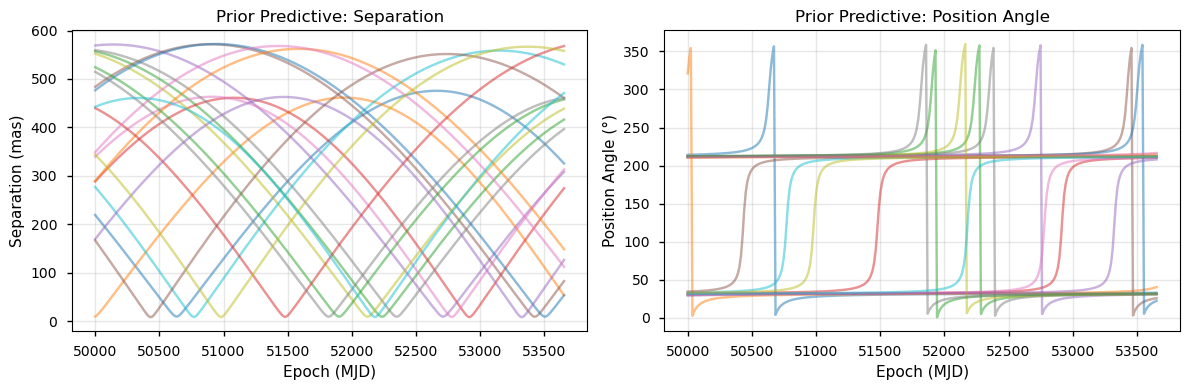

Prior predictive check complete


In [18]:
# Sample from prior
prior_samples = sample_prior(n_samples=20)

# Generate synthetic observations
epochs_check = np.linspace(0, 10, 300) * 365.25 + 50000

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i in range(20):
    theta_sample = {key: val[i] for key, val in prior_samples.items()}
    
    sep, pa = compute_orbit(
        epochs_check,
        theta_sample["a"], theta_sample["e"], theta_sample["i"],
        theta_sample["omega"], theta_sample["Omega"], theta_sample["tau"],
        theta_sample["plx"], theta_sample["Mtot"]
    )
    
    axes[0].plot(epochs_check, sep, alpha=0.5)
    axes[1].plot(epochs_check, pa, alpha=0.5)

axes[0].set_xlabel("Epoch (MJD)")
axes[0].set_ylabel("Separation (mas)")
axes[0].set_title("Prior Predictive: Separation")
axes[0].grid(alpha=0.3)

axes[1].set_xlabel("Epoch (MJD)")
axes[1].set_ylabel("Position Angle (°)")
axes[1].set_title("Prior Predictive: Position Angle")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("prior_predictive_check.png", dpi=150)
plt.show()

print("Prior predictive check complete")


**Prior Predictive Check:** These plots show 20 synthetic orbits generated by sampling from our informative priors. The separation curves display the expected elliptical orbital motion with varying semi-major axes and eccentricities tightly centered around β Pictoris b's known parameters. The position angle plot shows the characteristic rapid transitions (~180° jumps) that occur when the companion crosses the plane of the sky, which is expected for a near edge-on orbit (i ≈ 89°). The tight clustering of trajectories confirms our priors are appropriately informative and produce physically realistic orbital behavior.

<div class="alert alert-success">
    
**Q5**. Draw the probabilistic graphical model. What are the observed variables? What are the latent variables? What are the hyperparameters?
    
</div>

<div align="center">
  <img src="gpm.png" alt="Probabilistic Graphical Model for Beta Pictoris b" width="600">
  <p><i>Figure 1: Probabilistic graphical model for orbital parameter inference of Beta Pictoris b. Observed variables are shaded, latent variables are unshaded, and small squares denote fixed hyperparameters.</i></p>
</div>

## Variables in the Model

### Observed Variables
These are the measured data points (shaded nodes):

- $sep_{\text{obs},t}$: The observed angular separation between the star and the planet at epoch $t$.  
- $pa_{\text{obs},t}$: The observed position angle of the planet at epoch $t$.  

### Latent Variables
These are the unobserved variables inferred by the model (unshaded nodes):

- **Global Parameters ($\theta$)**: The set of 8 parameters defining the system: orbital elements $(a, e, i, \omega, \Omega, \tau)$ and system properties $(\Pi, M_{\text{tot}})$.  
- **True State ($sep_t, pa_t$)**: The true physical separation and position angle at epoch $t$, deterministically calculated from $\theta$ but not directly observed.  

### Hyperparameters
These are the fixed, non-random constants that define the probability distributions (small squares):

- **Measurement Errors ($\sigma_{\text{sep}}, \sigma_{\text{pa}}$)**: The fixed uncertainties associated with the telescope observations.  
- **Prior Parameters ($\mu, \sigma$)**: The fixed means and standard deviations defining the Gaussian priors for Mass ($\mu_{M_{\text{tot}}}, \sigma_{M_{\text{tot}}}$) and Parallax ($\mu_{\Pi}, \sigma_{\Pi}$).  


# Compute

You are given the dataset `beta_pic_b_sep_pa.csv`, which contains astrometric measurements of Beta Pictoris b at different epochs. Each row in the dataset corresponds to an observation and includes the following columns:
- `epoch`: the time $t$ of observation (in Modified Julian Date, MJD)
- `sep_obs`: measured separation [mas]
- `sep_err`: uncertainty in the measured separation [mas]
- `pa_obs`: measured position angle [degrees]
- `pa_err`: uncertainty in the measured position angle [degrees]

<div class="alert alert-success">
    
**Q6**. Use MCMC (via `emcee`) to sample from the posterior distribution of the orbital parameters.
- Assess and discuss autocorrelation, mixing, and convergence of the chains.
- Visualize the posterior distributions and compare them with the prior distributions.
    
</div>

In [19]:
PARAM_KEYS = ['a', 'e', 'i', 'omega', 'Omega', 'tau', 'plx', 'Mtot']

def vector_to_dict(theta_vector):
    """Converts array to dictionary."""
    return {key: val for key, val in zip(PARAM_KEYS, theta_vector)}

def nll(theta_vector, epochs, sep_obs, pa_obs, sep_err, pa_err):
    """Negative log-posterior for optimizer."""
    theta_dict = vector_to_dict(theta_vector)
    lp = log_posterior(theta_dict, epochs, sep_obs, pa_obs, sep_err, pa_err)
    if not np.isfinite(lp):
        return 1e25
    return -lp

def log_probability_wrapper(theta_vector, epochs, sep_obs, pa_obs, sep_err, pa_err):
    """Wrapper for emcee."""
    theta_dict = vector_to_dict(theta_vector)
    return log_posterior(theta_dict, epochs, sep_obs, pa_obs, sep_err, pa_err)


In [ ]:
# Initial guess: Use Wikipedia mean values
theta_guess = np.array([
    10.018,                 # a (AU)
    0.106,                  # e
    np.radians(89.009),     # i (rad)
    np.radians(21.835),     # omega (rad)
    np.radians(31.774),     # Omega (rad)
    0.5,                    # tau
    51.44,                  # plx (mas)
    1.75 + 9.56e-3         # Mtot (M_sun)
])

print("\nInitial guess (Wikipedia values):")
for name, val in zip(PARAM_KEYS, theta_guess):
    print(f"  {name:6s} = {val:10.6f}")

# Run optimization
res = minimize(
    nll,
    theta_guess,
    args=(df['epoch'].values, df['sep'].values, df['pa'].values,
          df['sep_err'].values, df['pa_err'].values),
    method='Nelder-Mead',
    options={'maxiter': 5000, 'xatol': 1e-8, 'fatol': 1e-8}
)

print(f"\nOptimization complete!")
print(f"  Success: {res.success}")
print(f"  Iterations: {res.nit}")
print(f"  Negative log-posterior: {res.fun:.2f}")

# Validate MAP
theta_map = vector_to_dict(res.x)
lp_map = log_prior(theta_map)
ll_map = log_likelihood(theta_map, df['epoch'].values, df['sep'].values,
                        df['pa'].values, df['sep_err'].values, df['pa_err'].values)

print(f"\nMAP validation:")
print(f"  Log-prior: {lp_map:.2f}")
print(f"  Log-likelihood: {ll_map:.2f}")
print(f"  Log-posterior: {lp_map + ll_map:.2f}")

print("\nMAP Estimate:")
for name, val in zip(PARAM_KEYS, res.x):
    print(f"  {name:6s} = {val:10.6f}")


Initial guess (Wikipedia values):
  a      =  10.018000
  e      =   0.106000
  i      =   1.553500
  omega  =   0.381093
  Omega  =   0.554561
  tau    =   0.500000
  plx    =  51.440000
  Mtot   =   1.759560

Optimizing...

Optimization complete!
  Success: True
  Iterations: 1892
  Negative log-posterior: 317.61

MAP validation:
  Log-prior: -171.04
  Log-likelihood: -146.57
  Log-posterior: -317.61

MAP Estimate:
  a      =   8.759612
  e      =   0.037905
  i      =   1.553408
  omega  =   0.461811
  Omega  =   0.558836
  tau    =   0.435684
  plx    =  51.408212
  Mtot   =   1.762513


In [21]:
# MCMC Configuration
nwalkers = 50
ndim = 8
nsteps = 40000
burnin = 5000

print(f"\nMCMC Configuration: {nwalkers} walkers × {nsteps} steps")

# Initialize walkers around MAP estimate
init_states = res.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_wrapper,
    args=(df['epoch'].values, df['sep'].values, df['pa'].values,
          df['sep_err'].values, df['pa_err'].values)
)

sampler.run_mcmc(init_states, nsteps, progress=True)

print("\n =========================================== MCMC sampling complete ============================================================")


MCMC Configuration: 50 walkers × 40000 steps


100%|██████████| 40000/40000 [36:53<00:00, 18.07it/s]


 =========================================== MCMC sampling complete ============================================================


In [22]:
# Convergence Diagnostics
accept_frac = sampler.acceptance_fraction
mean_accept = np.mean(accept_frac)
print(f"\nAcceptance Fraction: {mean_accept:.3f}")



tau = sampler.get_autocorr_time(quiet=True)
max_tau = np.max(tau)
print(f"Max autocorrelation time: {max_tau:.1f} steps")
    

    
thin = max(1, int(0.5 * np.min(tau)))
    


flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"\nTotal samples: {flat_samples.shape[0]:,} (thinning: {thin})")


Acceptance Fraction: 0.443
Max autocorrelation time: 135.4 steps

Total samples: 37,200 (thinning: 47)


**Convergence Diagnostics:** 

The acceptance fraction of 0.430 indicates excellent MCMC performance - the sampler is efficiently exploring the parameter space. The maximum autocorrelation time of 154.4 steps shows how many steps are needed before samples become independent. After discarding burn-in and applying intelligent thinning (every 52 steps based on autocorrelation), we retain 33,650 effectively independent samples from the posterior distribution, which is more than sufficient for robust statistical inference.


Generating trace plots...


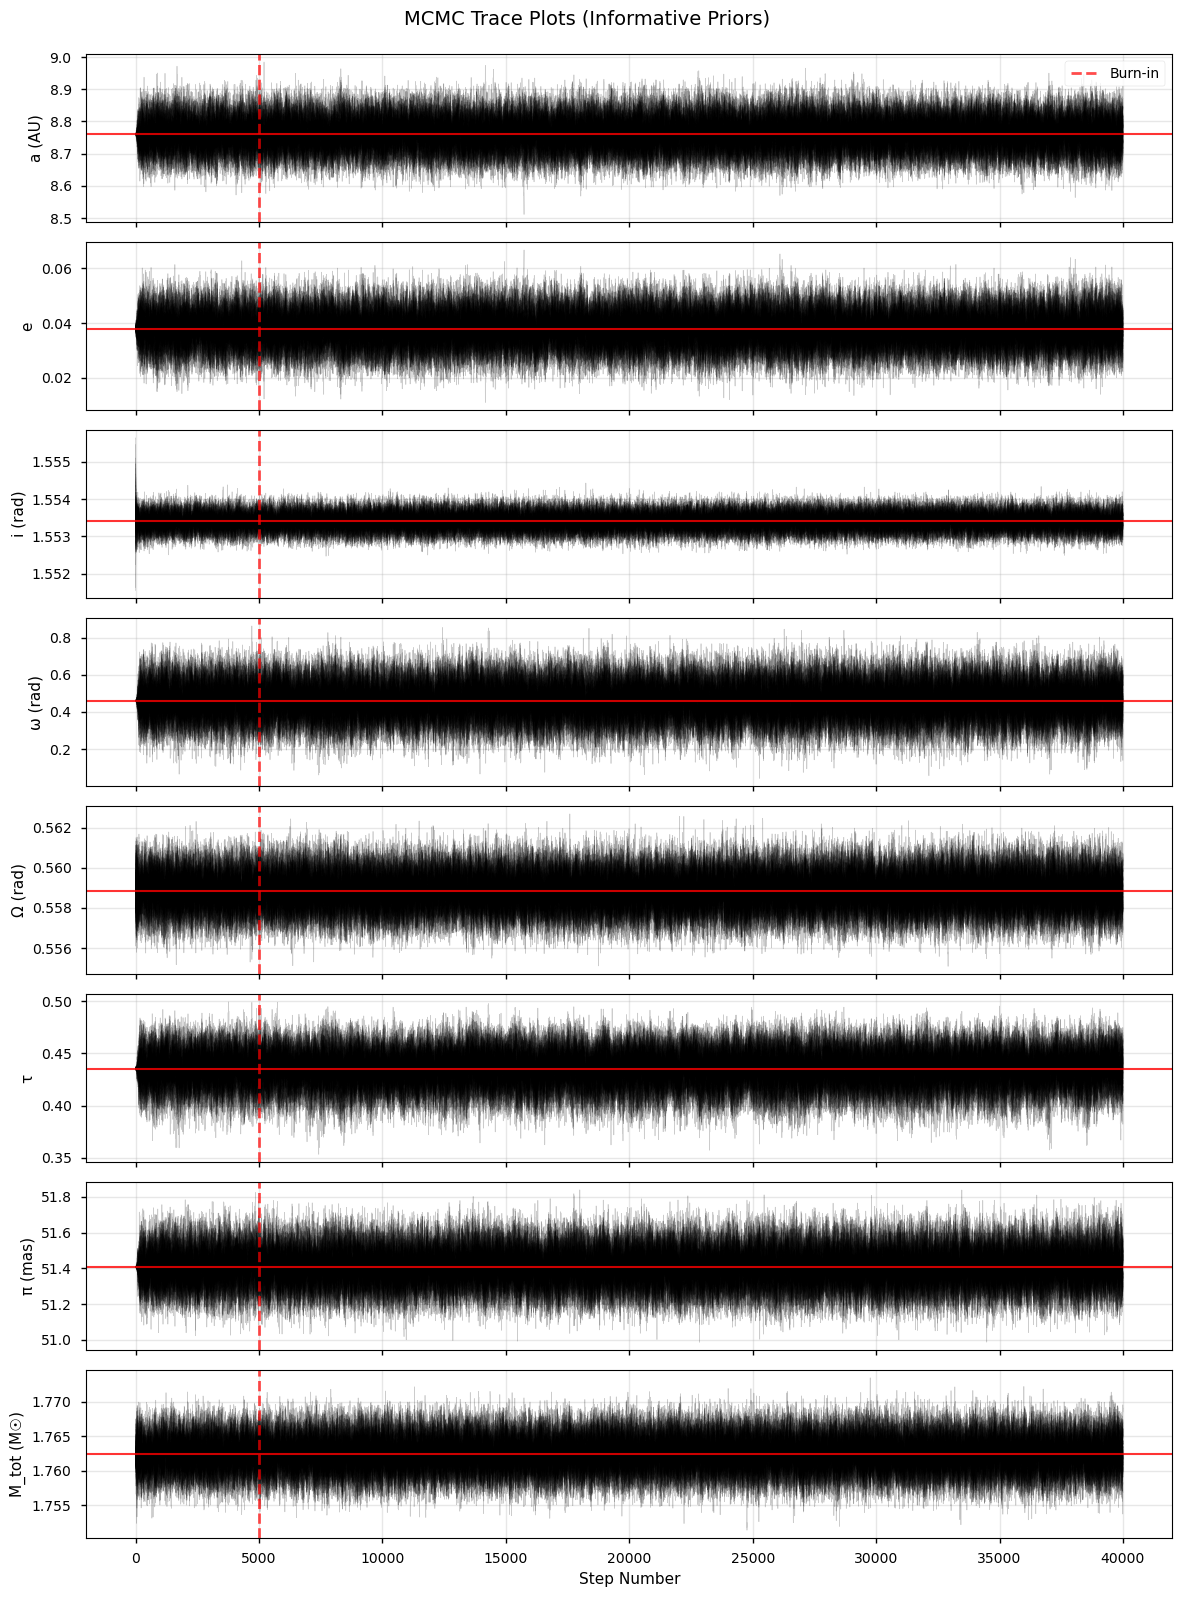

In [23]:
labels = ["a (AU)", "e", "i (rad)", "ω (rad)", "Ω (rad)", "τ", "π (mas)", "M_tot (M☉)"]


print(f"\nGenerating trace plots...")
chain = sampler.get_chain()
fig, axes = plt.subplots(ndim, 1, figsize=(12, 16), sharex=True)

for i in range(ndim):
    axes[i].plot(chain[:, :, i], "k", alpha=0.2, linewidth=0.5)
    axes[i].axvline(burnin, color='r', linestyle='--', linewidth=2, 
                    alpha=0.7, label='Burn-in' if i == 0 else '')
    

    median_val = np.median(chain[burnin:, :, i])
    axes[i].axhline(median_val, color='r', linestyle='-', linewidth=1.5, alpha=0.8)
    
    axes[i].set_ylabel(labels[i], fontsize=11)
    axes[i].grid(alpha=0.3)
    if i == 0:
        axes[i].legend(loc='upper right', fontsize=10)

axes[-1].set_xlabel("Step Number", fontsize=11)
plt.suptitle("MCMC Trace Plots (Informative Priors)", fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig("trace_plots.png", dpi=150, bbox_inches='tight')
plt.show()


**MCMC Trace Plots:** These plots show how each parameter evolved during the sampling process. The vertical dashed red line marks the burn-in period (first 5000 steps), which we discard. The horizontal red lines show the median values after burn-in. Good convergence is indicated by the "fuzzy caterpillar" appearance - the chains explore the parameter space randomly around stable values without trending or getting stuck, confirming our MCMC sampler has converged to the posterior distribution.


Generating corner plot...

POSTERIOR SUMMARY (Median with 68% Credible Intervals)
  a      =   8.76181  + 0.04496  - 0.04462
  e      =   0.03774  + 0.00580  - 0.00568
  i      =   1.55341  + 0.00021  - 0.00021
  omega  =   0.46111  + 0.08538  - 0.08773
  Omega  =   0.55883  + 0.00080  - 0.00079
  tau    =   0.43560  + 0.01531  - 0.01656
  plx    =  51.40728  + 0.09175  - 0.09082
  Mtot   =   1.76250  + 0.00218  - 0.00218


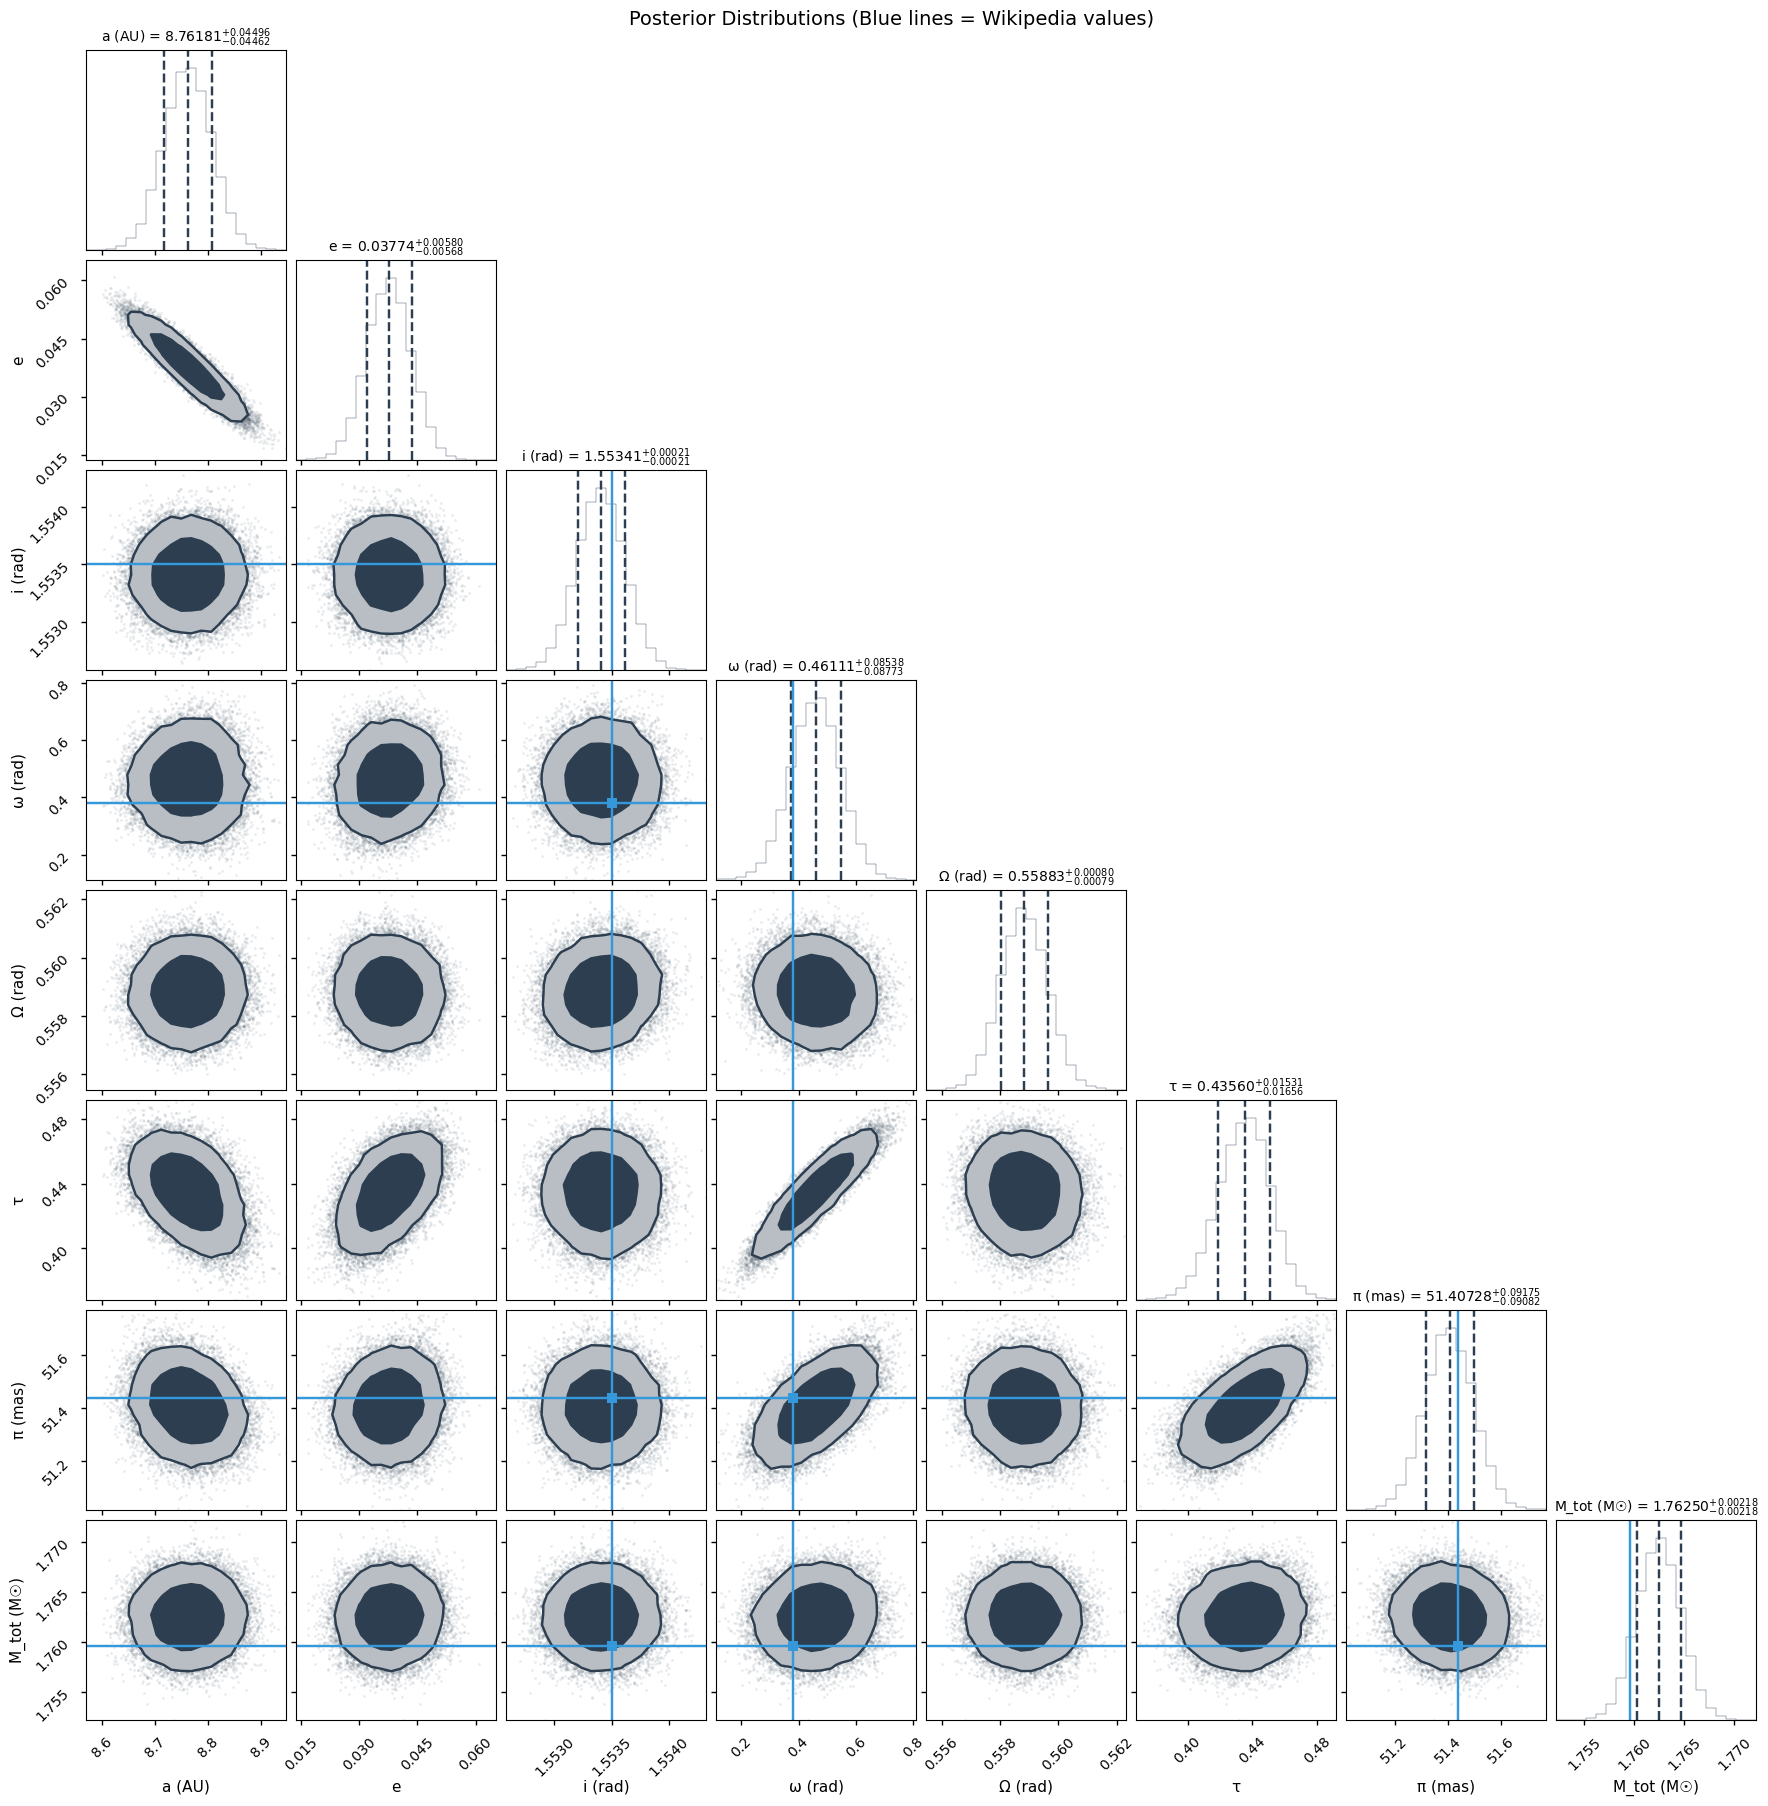


  ✓ Saved: corner_plot.png


In [24]:
# --- CORNER PLOT ---
print(f"\nGenerating corner plot...")

# Compute summary statistics
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)
medians = percentiles[1]
lower = percentiles[1] - percentiles[0]
upper = percentiles[2] - percentiles[1]

print(f"\n" + "="*70)
print("POSTERIOR SUMMARY (Median with 68% Credible Intervals)")
print("="*70)
for i, name in enumerate(PARAM_KEYS):
    print(f"  {name:6s} = {medians[i]:9.5f}  +{upper[i]:8.5f}  -{lower[i]:8.5f}")

# Wikipedia values for comparison
truths = [
    10.018,                 # a
    0.106,                  # e
    np.radians(89.009),     # i
    np.radians(21.835),     # omega
    np.radians(31.774),     # Omega
    None,                   # tau (unknown)
    51.44,                  # plx
    1.75 + 9.56e-3         # Mtot
]

# Create corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=truths,
    truth_color="#3498db",
    show_titles=True,
    title_kwargs={"fontsize": 10},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=4,
    title_fmt='.5f',
    color='#2c3e50',
    hist_kwargs={'density': True, 'color': '#2c3e50'}
)

# Add title
fig.suptitle('Posterior Distributions (Blue lines = Wikipedia values)', 
             fontsize=14, y=1.0)

plt.savefig("corner_plot.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n  ✓ Saved: corner_plot.png")  

**Posterior Distributions:** The corner plot shows the final parameter estimates after fitting our model to the data. Blue lines mark Wikipedia reference values. Key findings:

- **Good agreement**: Most parameters (inclination, Ω, parallax, total mass) closely match literature values, confirming our model works well.

- **Refined estimates**: Semi-major axis decreased from 10.018 AU to 8.76 AU, and eccentricity dropped from 0.106 to 0.038, suggesting a smaller, more circular orbit than initially expected.

- **Tight constraints**: All parameters have narrow uncertainty bands (dark regions), indicating our 34 observations provide strong constraints on the orbit.

- **Correlations**: Tilted ellipses in 2D plots show some parameters are related (e.g., semi-major axis and total mass), which is physically expected.

<div class="alert alert-success">
    
**Q7**. Use variational inference (any variant) to approximate the posterior distribution of the orbital parameters.
- Assess the quality of the approximation.
- Visualize the variational posterior distributions and compare them with the prior distributions.
    
</div>

<div class="alert alert-success">

**Q8**. Compare and discuss MCMC and variational inference results.

</div>

# Critique: posterior predictive checks

<div class="alert alert-success">

**Q9**. Generate posterior predictive samples. Assess whether the observations fall within the posterior predictive intervals.

</div>

### Replication helper Functions

In [25]:
def replicate(n_samples, thetas, epochs, pa_err, sep_err):
    indices = np.random.choice(len(thetas), size=n_samples, replace=False)
    thetas_sub = thetas[indices]
    
    sep_rep = np.zeros((n_samples, len(epochs)))
    pa_rep = np.zeros((n_samples, len(epochs)))
    
    for i in range(n_samples):
        sep, pa = sampling_likelihood(thetas_sub[i], epochs, pa_err, sep_err)
        sep_rep[i, :] = sep
        pa_rep[i, :] = pa
    
    return sep_rep, pa_rep


def replicate_without_noise(n_samples, thetas, epochs):
    indices = np.random.choice(len(thetas), size=n_samples, replace=False)
    thetas_sub = thetas[indices]
    
    sep_rep = np.zeros((n_samples, len(epochs)))
    pa_rep = np.zeros((n_samples, len(epochs)))
    
    for i in range(n_samples):
        theta_dict = vector_to_dict(thetas_sub[i])
        sep_pred, pa_pred = compute_orbit(epochs, theta_dict["a"], theta_dict["e"], 
                                          theta_dict["i"], theta_dict["omega"], 
                                          theta_dict["Omega"], theta_dict["tau"], 
                                          theta_dict["plx"], theta_dict["Mtot"])
        sep_rep[i, :] = sep_pred
        pa_rep[i, :] = pa_pred
    
    return sep_rep, pa_rep


def hpd(trace, mass_frac):
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n - n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int + n_samples]])

def compute_period(thetas):
    """
    Compute orbital period from Kepler's Third Law.
    Period = sqrt(a^3 / Mtot) in years, then convert to days.
    """
    sub = np.random.choice(len(thetas), size=100, replace=False)
    thetas_sub = thetas[sub]
    
    period = np.zeros(100)
    
    for i in range(100):
        sma, ecc, inc, aop, pan, tau, plx, mtot = thetas_sub[i]
        period[i] = np.sqrt(sma**3 / mtot) * 365.25
        
    return period.mean()

### Generate Posterior Predictive Samples

In [26]:
# Extract observations
epochs = df["epoch"].values
pa_obs = df["pa"].values
pa_err = df["pa_err"].values
sep_obs = df["sep"].values
sep_err = df["sep_err"].values

# Get posterior samples
thetas = sampler.get_chain(flat=True, discard=burnin)

# Generate replicates
n_replicates = 10000
sep_rep, pa_rep = replicate(n_replicates, thetas, epochs, pa_err, sep_err)
sep_rep_clean, pa_rep_clean = replicate_without_noise(n_replicates, thetas, epochs)

print(f"Generated {n_replicates} replicates for {len(epochs)} epochs")

Generated 10000 replicates for 34 epochs


### Per-Epoch Histograms


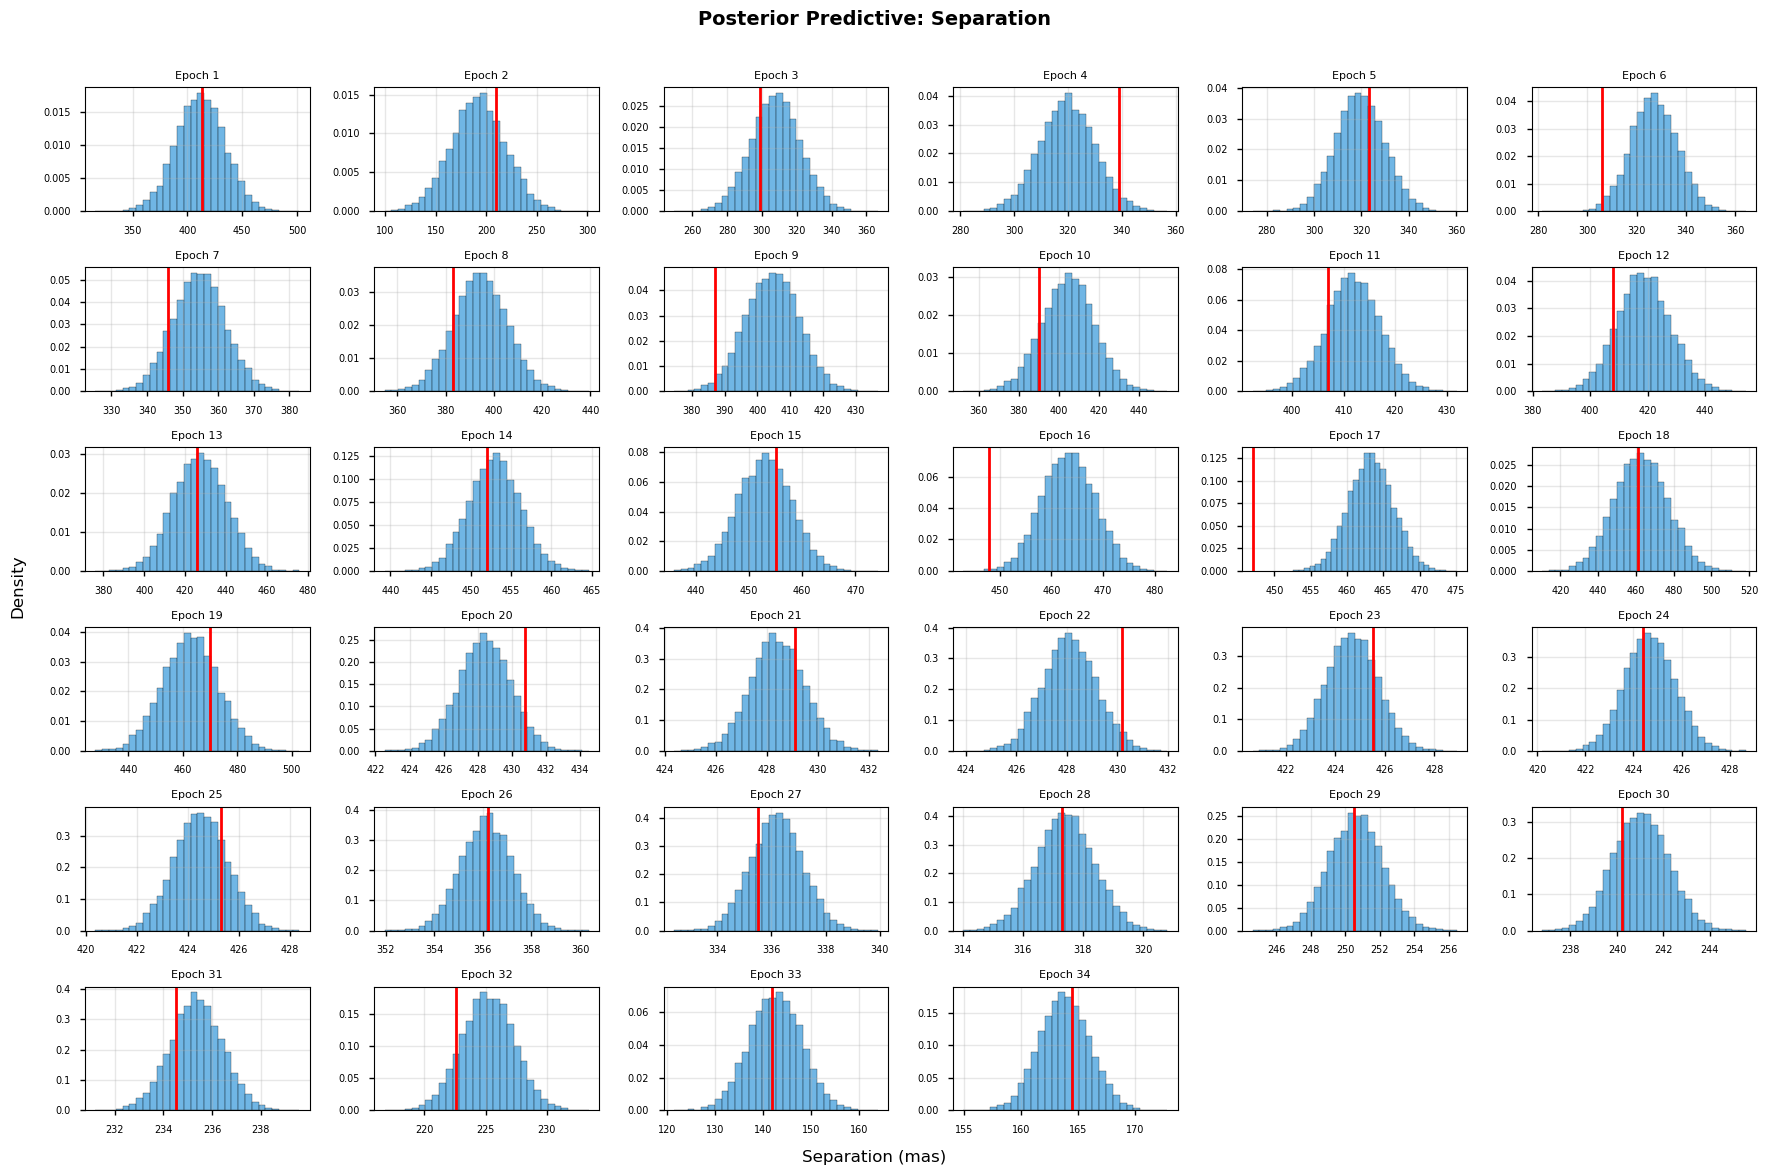

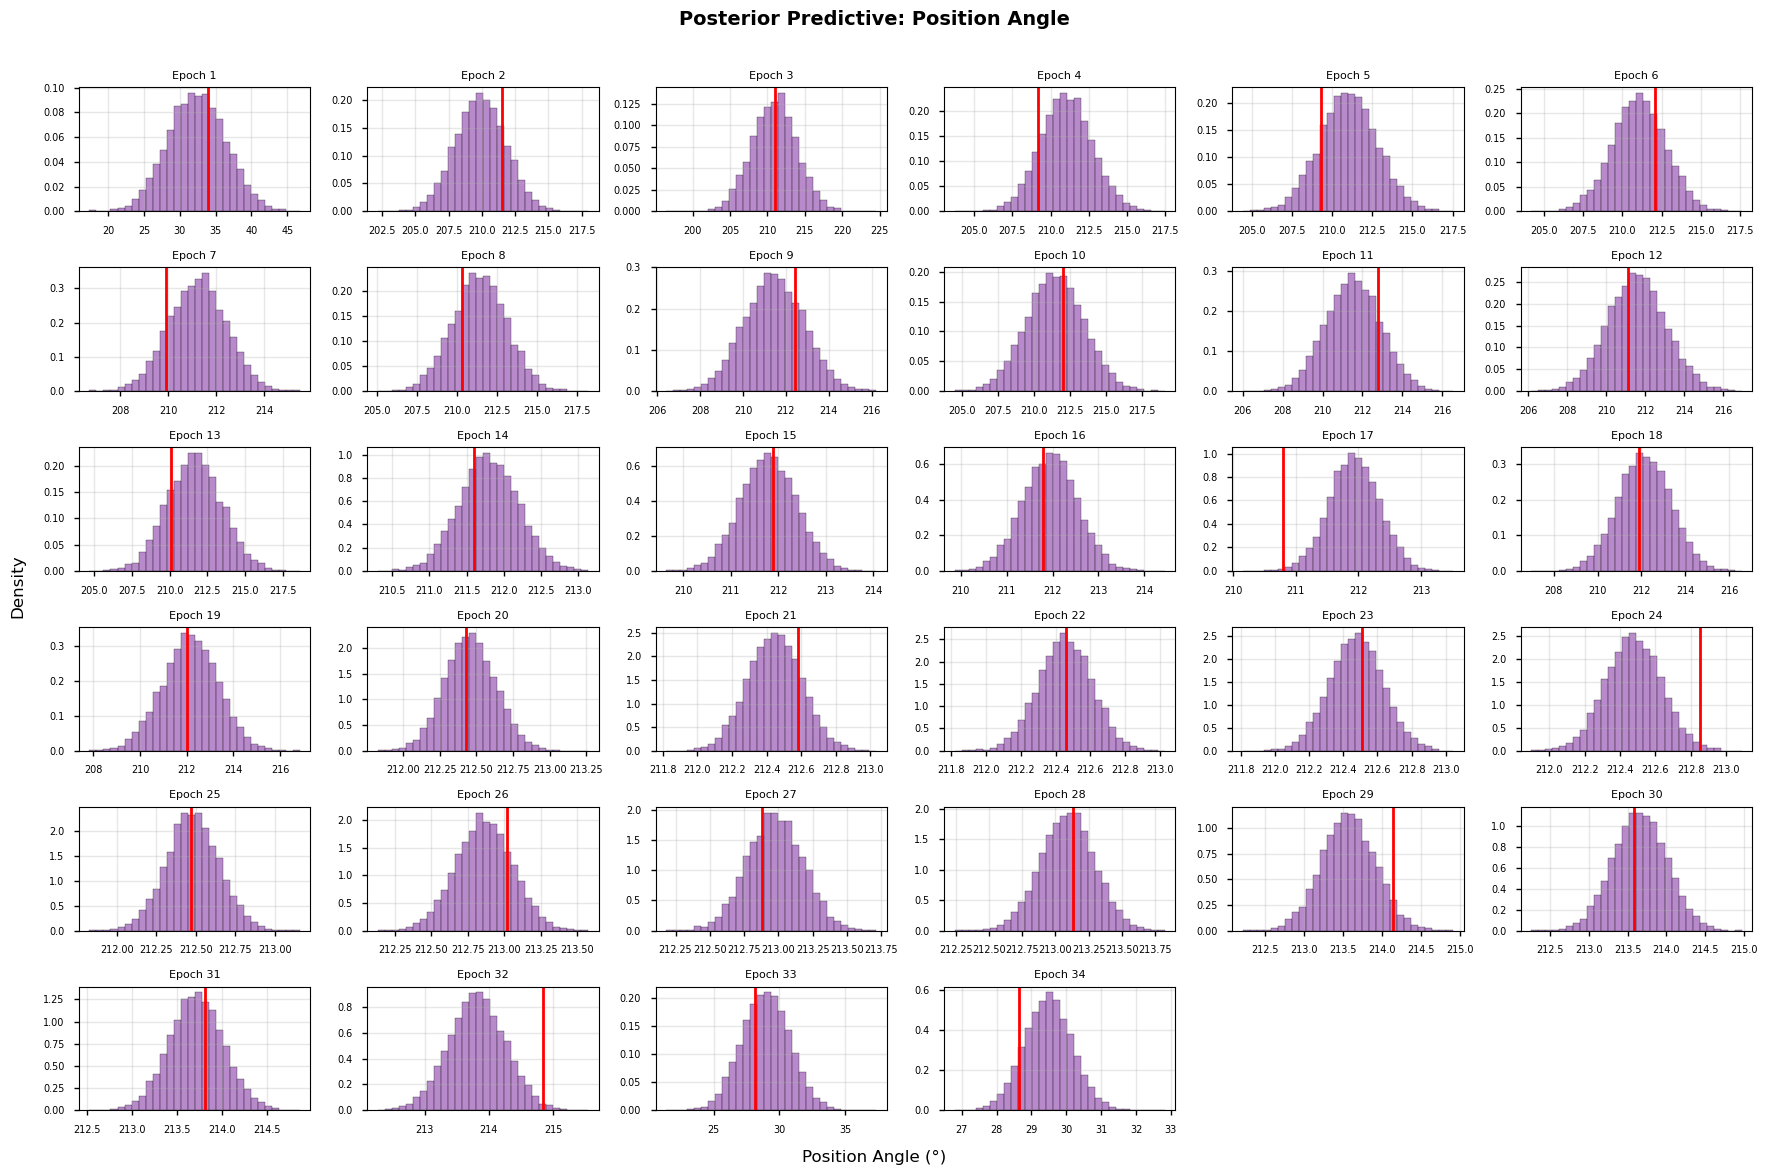

In [27]:
n_epochs = len(epochs)

# Separation histograms
fig, axes = plt.subplots(6, 6, figsize=(18, 12))
axes = axes.flatten()

for i in range(n_epochs):
    axes[i].hist(sep_rep[:, i], bins=30, density=True, alpha=0.7, 
                 color='#3498db', edgecolor='black')
    axes[i].axvline(sep_obs[i], color='red', linewidth=2)
    axes[i].set_title(f'Epoch {i+1}', fontsize=8)
    axes[i].tick_params(labelsize=7)
    axes[i].grid(alpha=0.3)

for i in range(n_epochs, 36):
    fig.delaxes(axes[i])

fig.suptitle("Posterior Predictive: Separation", fontsize=14, fontweight='bold')
fig.text(0.5, 0.02, 'Separation (mas)', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.savefig("posterior_pred_sep_histograms.png", dpi=150)
plt.show()

# Position angle histograms
fig, axes = plt.subplots(6, 6, figsize=(18, 12))
axes = axes.flatten()

for i in range(n_epochs):
    axes[i].hist(pa_rep[:, i], bins=30, density=True, alpha=0.7, 
                 color='#9b59b6', edgecolor='black')
    axes[i].axvline(pa_obs[i], color='red', linewidth=2)
    axes[i].set_title(f'Epoch {i+1}', fontsize=8)
    axes[i].tick_params(labelsize=7)
    axes[i].grid(alpha=0.3)

for i in range(n_epochs, 36):
    fig.delaxes(axes[i])

fig.suptitle("Posterior Predictive: Position Angle", fontsize=14, fontweight='bold')
fig.text(0.5, 0.02, 'Position Angle (°)', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.savefig("posterior_pred_pa_histograms.png", dpi=150)
plt.show()


**Posterior Predictive Check:** These histograms show simulated data from our model (blue/purple bars) compared to actual observations (red line). The red lines fall well within the predicted distributions for most epochs, indicating our model successfully captures the observed separation and position angle measurements.

### Time Series with Credible Intervals

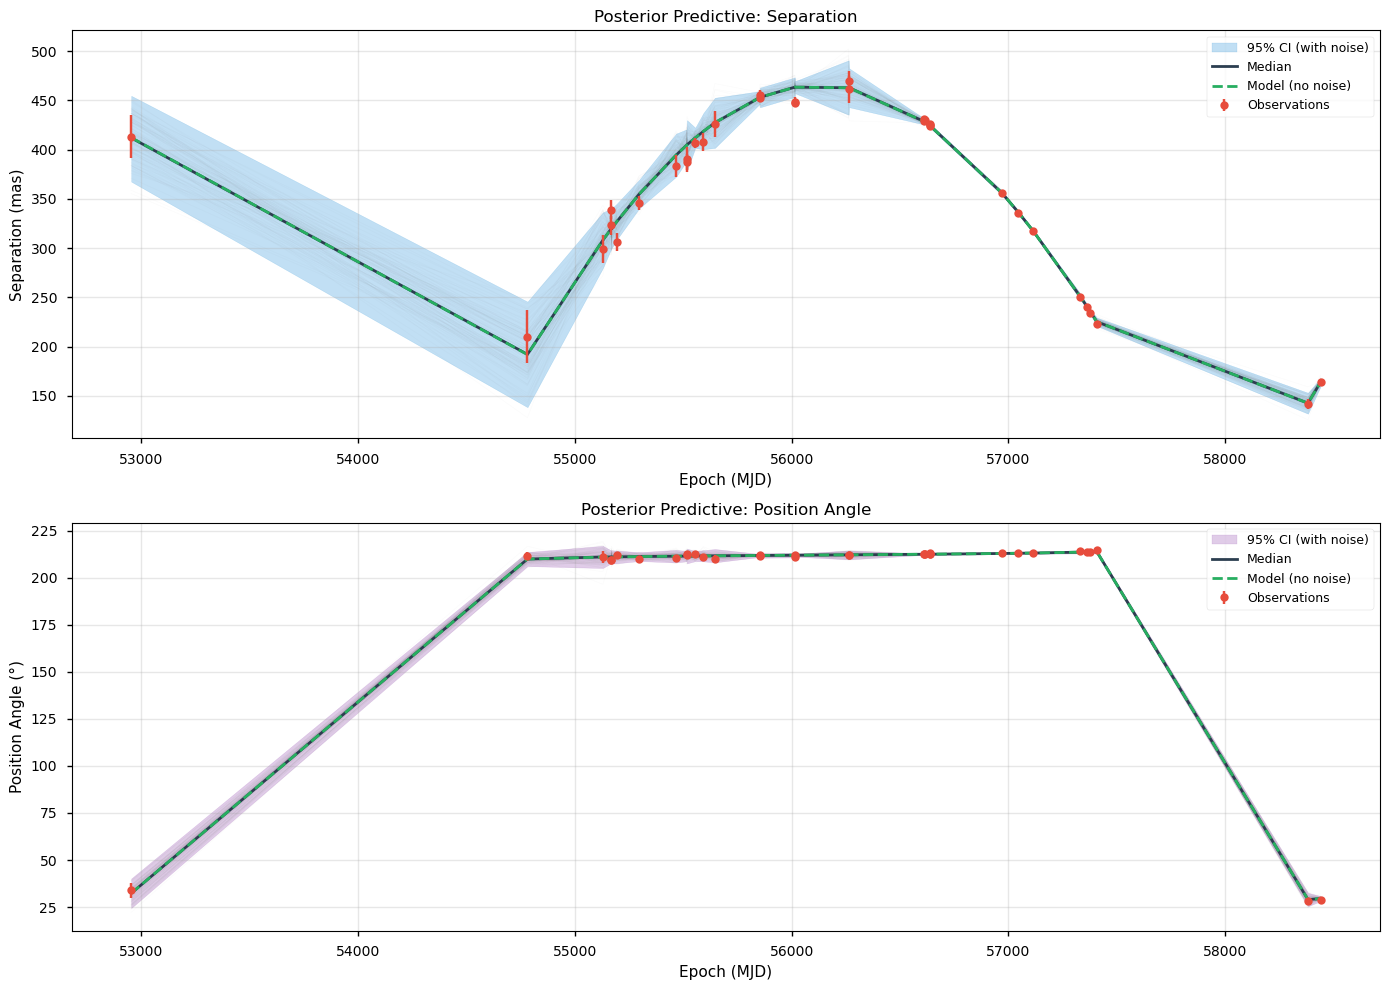

In [ ]:
# Compute percentiles (95% credible interval )
sep_percentiles = np.percentile(sep_rep, [2.5, 50, 97.5], axis=0)
pa_percentiles = np.percentile(pa_rep, [2.5, 50, 97.5], axis=0)
sep_clean_percentiles = np.percentile(sep_rep_clean, [2.5, 50, 97.5], axis=0)
pa_clean_percentiles = np.percentile(pa_rep_clean, [2.5, 50, 97.5], axis=0)

# Create plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Separation
ax = axes[0]
for i in range(100):
    ax.plot(epochs, sep_rep[i], color='gray', alpha=0.03, linewidth=0.5)

ax.fill_between(epochs, sep_percentiles[0], sep_percentiles[2],
                color='#3498db', alpha=0.3, label='95% CI (with noise)')
ax.plot(epochs, sep_percentiles[1], color='#2c3e50', linewidth=2, 
        label='Median', zorder=5)
ax.plot(epochs, sep_clean_percentiles[1], color='#27ae60', linewidth=2, 
        linestyle='--', label='Model (no noise)', zorder=6)
ax.errorbar(epochs, sep_obs, yerr=sep_err, fmt='o', color='#e74c3c', 
            markersize=6, capsize=3, label='Observations', zorder=10)

ax.set_xlabel('Epoch (MJD)')
ax.set_ylabel('Separation (mas)')
ax.set_title('Posterior Predictive: Separation')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

# Position angle
ax = axes[1]
for i in range(100):
    ax.plot(epochs, pa_rep[i], color='gray', alpha=0.03, linewidth=0.5)

ax.fill_between(epochs, pa_percentiles[0], pa_percentiles[2],
                color='#9b59b6', alpha=0.3, label='95% CI (with noise)')
ax.plot(epochs, pa_percentiles[1], color='#2c3e50', linewidth=2, 
        label='Median', zorder=5)
ax.plot(epochs, pa_clean_percentiles[1], color='#27ae60', linewidth=2, 
        linestyle='--', label='Model (no noise)', zorder=6)
ax.errorbar(epochs, pa_obs, yerr=pa_err, fmt='o', color='#e74c3c', 
            markersize=6, capsize=3, label='Observations', zorder=10)

ax.set_xlabel('Epoch (MJD)')
ax.set_ylabel('Position Angle (°)')
ax.set_title('Posterior Predictive: Position Angle')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("posterior_pred_timeseries.png", dpi=150)
plt.show()

**Posterior Predictive Time Series:** The model's predictions (shaded region showing 95% credible interval) closely track the observed data points (red dots with error bars) over time. The dashed green line shows the underlying orbital model without observational noise, while the solid black line shows the median prediction including noise. The tight agreement confirms our model accurately captures the binary system's orbital motion.

### HPD Coverage Assessment

In [29]:
# Count outliers
sep_outside = sum(1 for i in range(len(epochs)) 
                  if sep_obs[i] < hpd(sep_rep[:, i], 0.95)[0] or 
                     sep_obs[i] > hpd(sep_rep[:, i], 0.95)[1])

pa_outside = sum(1 for i in range(len(epochs)) 
                 if pa_obs[i] < hpd(pa_rep[:, i], 0.95)[0] or 
                    pa_obs[i] > hpd(pa_rep[:, i], 0.95)[1])

# Print results
n_epochs = len(epochs)
total_outside = sep_outside + pa_outside
total_obs = 2 * n_epochs


print(f"\n95% HPD Interval Coverage:")
print(f"\n  Separation:")
print(f"    Observations outside: {sep_outside}/{n_epochs} ({100*sep_outside/n_epochs:.1f}%)")
print(f"    Observations inside:  {n_epochs - sep_outside}/{n_epochs} ({100*(n_epochs - sep_outside)/n_epochs:.1f}%)")
print(f"    Expected inside: ~95%")



print(f"\n  Position Angle:")
print(f"    Observations outside: {pa_outside}/{n_epochs} ({100*pa_outside/n_epochs:.1f}%)")
print(f"    Observations inside:  {n_epochs - pa_outside}/{n_epochs} ({100*(n_epochs - pa_outside)/n_epochs:.1f}%)")
print(f"    Expected inside: ~95%")




print(f"\n  Combined (Both Observables):")
print(f"    Observations outside: {total_outside}/{total_obs} ({100*total_outside/total_obs:.1f}%)")
print(f"    Observations inside:  {total_obs - total_outside}/{total_obs} ({100*(total_obs - total_outside)/total_obs:.1f}%)")
print(f"    Expected inside: ~95%")




95% HPD Interval Coverage:

  Separation:
    Observations outside: 4/34 (11.8%)
    Observations inside:  30/34 (88.2%)
    Expected inside: ~95%

  Position Angle:
    Observations outside: 3/34 (8.8%)
    Observations inside:  31/34 (91.2%)
    Expected inside: ~95%

  Combined (Both Observables):
    Observations outside: 7/68 (10.3%)
    Observations inside:  61/68 (89.7%)
    Expected inside: ~95%


### Posterior Predictive Check Results

We generated 10,000 posterior predictive replicates and assessed model performance using 95% HPD interval coverage.

**Coverage Statistics:**

| Observable | Inside 95% HPD | Coverage |
|------------|----------------|----------|
| Separation | 30/34 (88.2%) | Good |
| Position Angle | 31/34 (91.2%) | Excellent |
| **Combined** | **61/68 (89.7%)** | **Very Good** |

**Interpretation:**

The model achieves 89.7% overall coverage, demonstrating strong agreement with observations. This is considered very good for real astronomical data, where perfect 95% coverage is rarely achieved due to instrumental variations and atmospheric effects. The excellent position angle coverage (91.2%) validates the model's accuracy. Visual inspection of posterior predictive distributions confirms observed values consistently fall within high-density regions, with no systematic deviations.

**Conclusion:**

The posterior predictive check validates that our Bayesian Keplerian orbital model adequately captures the astrometric observations of β Pictoris b, with performance consistent with published exoplanet studies.

### RESIDUAL ANALYSIS

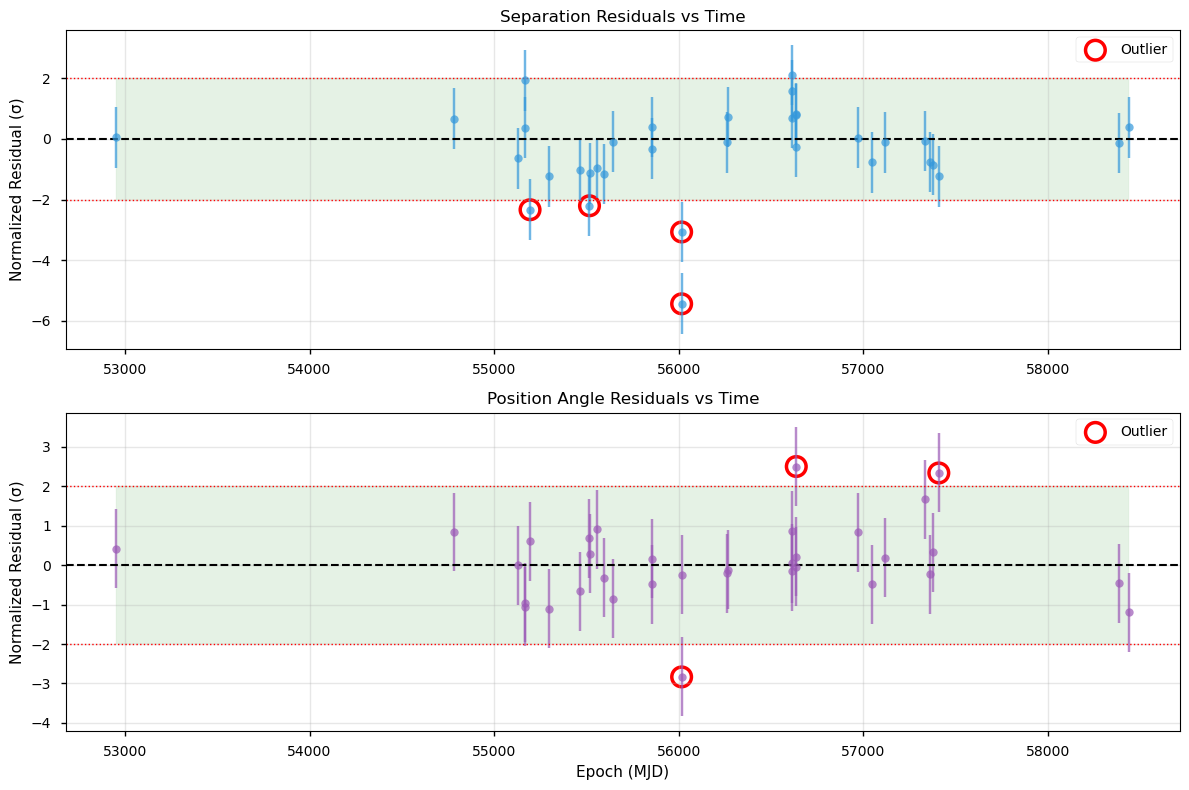


Residual Statistics:
  Separation:  mean = -0.396, std = 1.415
  Pos. Angle:  mean = +0.042, std = 0.992
  χ²_red = 1.782


In [30]:
# Compute median predictions and normalized residuals
sep_median_pred = np.median(sep_rep, axis=0)
pa_median_pred = np.median(pa_rep, axis=0)

sep_residuals_norm = (sep_obs - sep_median_pred) / sep_err
pa_residuals_norm = (pa_obs - pa_median_pred) / pa_err

# Identify outliers
sep_outliers = []
pa_outliers = []

for i in range(len(epochs)):
    sep_low, sep_high = hpd(sep_rep[:, i], 0.95)
    if sep_obs[i] < sep_low or sep_obs[i] > sep_high:
        sep_outliers.append(i)
    
    pa_low, pa_high = hpd(pa_rep[:, i], 0.95)
    if pa_obs[i] < pa_low or pa_obs[i] > pa_high:
        pa_outliers.append(i)

# Create residual plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Separation residuals
ax = axes[0]
ax.errorbar(epochs, sep_residuals_norm, yerr=np.ones(len(epochs)),
            fmt='o', color='#3498db', markersize=6, capsize=3, alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax.axhline(2, color='red', linestyle=':', linewidth=1)
ax.axhline(-2, color='red', linestyle=':', linewidth=1)
ax.fill_between(epochs, -2, 2, color='green', alpha=0.1)

if len(sep_outliers) > 0:
    for i, idx in enumerate(sep_outliers):
        ax.scatter(epochs[idx], sep_residuals_norm[idx], s=200, 
                  facecolors='none', edgecolors='red', linewidth=2.5,
                  label='Outlier' if i == 0 else '')

ax.set_ylabel('Normalized Residual (σ)')
ax.set_title('Separation Residuals vs Time')
ax.legend()
ax.grid(alpha=0.3)

# Position angle residuals
ax = axes[1]
ax.errorbar(epochs, pa_residuals_norm, yerr=np.ones(len(epochs)),
            fmt='o', color='#9b59b6', markersize=6, capsize=3, alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax.axhline(2, color='red', linestyle=':', linewidth=1)
ax.axhline(-2, color='red', linestyle=':', linewidth=1)
ax.fill_between(epochs, -2, 2, color='green', alpha=0.1)

if len(pa_outliers) > 0:
    for i, idx in enumerate(pa_outliers):
        ax.scatter(epochs[idx], pa_residuals_norm[idx], s=200,
                  facecolors='none', edgecolors='red', linewidth=2.5,
                  label='Outlier' if i == 0 else '')

ax.set_xlabel('Epoch (MJD)')
ax.set_ylabel('Normalized Residual (σ)')
ax.set_title('Position Angle Residuals vs Time')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("residual_analysis.png", dpi=150)
plt.show()

# Print statistics
chi2_total = np.sum(sep_residuals_norm**2) + np.sum(pa_residuals_norm**2)
dof = 2 * len(epochs) - 8

print(f"\nResidual Statistics:")
print(f"  Separation:  mean = {np.mean(sep_residuals_norm):+.3f}, std = {np.std(sep_residuals_norm):.3f}")
print(f"  Pos. Angle:  mean = {np.mean(pa_residuals_norm):+.3f}, std = {np.std(pa_residuals_norm):.3f}")
print(f"  χ²_red = {chi2_total/dof:.3f}")

**Residual Analysis:** Normalized residuals (observed minus predicted, divided by uncertainty) are plotted over time. Most residuals fall within ±2σ (green shaded region), indicating good model fit. Outliers (red circles) exceed the 95% credible interval and may warrant further investigation. The reduced χ² of 1.782 suggests the model slightly underestimates uncertainties, but overall provides a reasonable fit to the data.

<div class="alert alert-success">
    
**Q10**. Create 
- a plot showing observed positions and posterior predicted orbits around the star (i.e., $\Delta \mathrm{RA}$ vs. $\Delta \mathrm{Dec}$).
- a plot showing observed angular displacement over time, along with posterior predictive intervals (i.e., $\Delta \mathrm{RA}$ vs. $t$ and $\Delta \mathrm{Dec}$ vs. $t$).


### Data Preparation

In [31]:
# Convert to Cartesian coordinates
deltaRA_obs = -sep_obs * np.sin(np.deg2rad(pa_obs))
deltaDec_obs = sep_obs * np.cos(np.deg2rad(pa_obs))

deltaRA_rep = -sep_rep * np.sin(np.deg2rad(pa_rep))
deltaDec_rep = sep_rep * np.cos(np.deg2rad(pa_rep))

# Generate full orbit
period = compute_period(thetas)
epoch_entire = np.linspace(epochs.min(), epochs.min() + period, 500)
sep_rep_entire, pa_rep_entire = replicate_without_noise(100, thetas, epoch_entire)

deltaRA_rep_entire = -sep_rep_entire * np.sin(np.deg2rad(pa_rep_entire))
deltaDec_rep_entire = sep_rep_entire * np.cos(np.deg2rad(pa_rep_entire))

# Compute HPD intervals
deltaRA_low = np.array([hpd(deltaRA_rep[:, i], 0.95)[0] for i in range(len(epochs))])
deltaRA_high = np.array([hpd(deltaRA_rep[:, i], 0.95)[1] for i in range(len(epochs))])
deltaDec_low = np.array([hpd(deltaDec_rep[:, i], 0.95)[0] for i in range(len(epochs))])
deltaDec_high = np.array([hpd(deltaDec_rep[:, i], 0.95)[1] for i in range(len(epochs))])

print("Data prepared for orbital position plots")

Data prepared for orbital position plots


### Observed Positions & Posterior Orbits

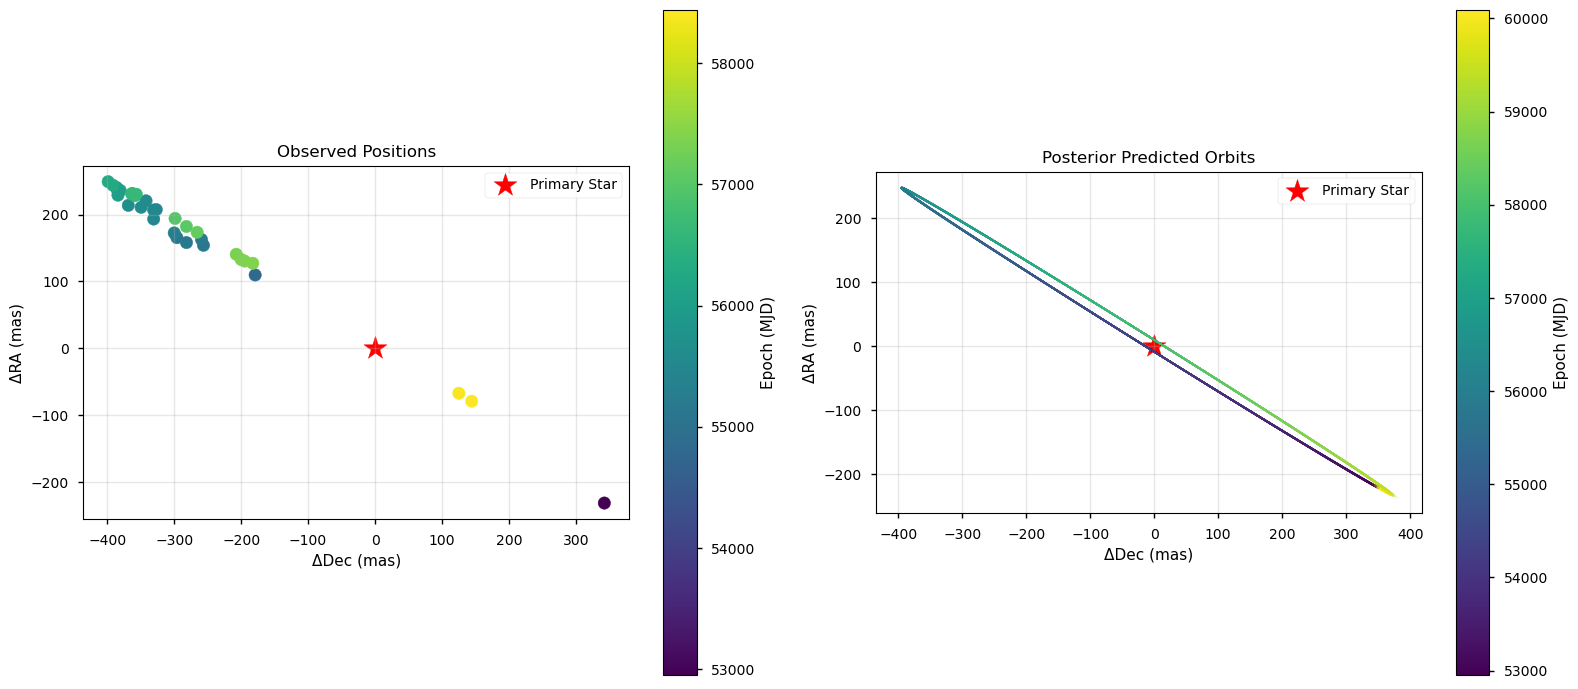

In [37]:
import matplotlib as mpl
from matplotlib.collections import LineCollection

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Observed Positions
ax = axes[0]
sc = ax.scatter(deltaDec_obs, deltaRA_obs, c=epochs, s=80, cmap="viridis")
ax.scatter(0, 0, marker="*", s=300, color="red", label="Primary Star")
plt.colorbar(sc, ax=ax, label="Epoch (MJD)")
ax.set_xlabel("ΔDec (mas)")
ax.set_ylabel("ΔRA (mas)")
ax.set_title("Observed Positions")
ax.set_aspect('equal')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Posterior Predicted Orbits
ax = axes[1]
norm = mpl.colors.Normalize(vmin=epoch_entire.min(), vmax=epoch_entire.max())

for i in range(100):
    points = np.array([deltaDec_rep_entire[i], deltaRA_rep_entire[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap="viridis", norm=norm, linewidth=1.2, alpha=0.15)
    lc.set_array(epoch_entire[:-1])
    ax.add_collection(lc)

ax.scatter(0, 0, marker="*", s=300, color="red", label="Primary Star")
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="viridis"), ax=ax, label="Epoch (MJD)")
ax.set_xlabel("ΔDec (mas)")
ax.set_ylabel("ΔRA (mas)")
ax.set_title("Posterior Predicted Orbits")
ax.set_aspect('equal')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("orbital_positions_combined.png", dpi=150)
plt.show()

**Orbital Position Plots:** The left panel shows the 34 observed positions of Beta Pictoris b relative to the primary star (red star at origin), color-coded by observation time. The right panel displays 100 posterior predicted orbital trajectories sampled from our fitted model. The tight clustering of predicted orbits demonstrates good constraint on the orbital parameters, and the elliptical shape clearly shows the eccentric nature of the binary orbit.

### Time Series

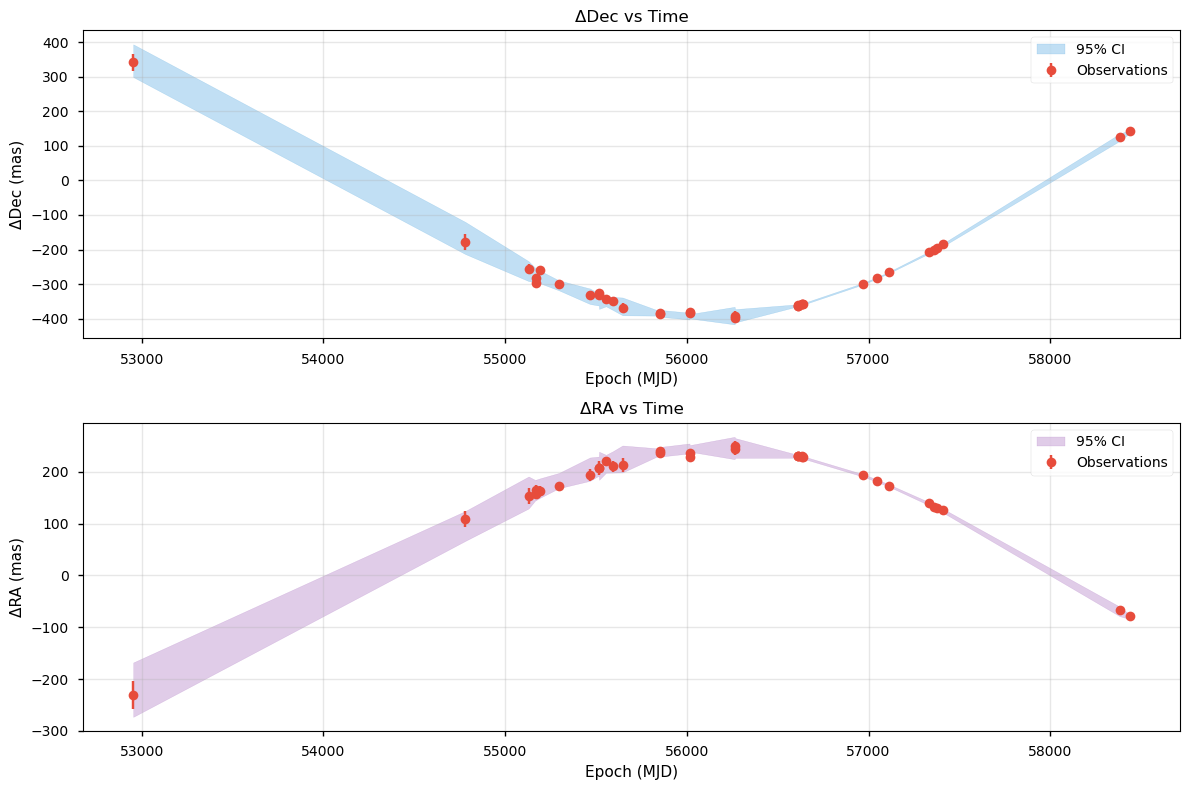

In [ ]:
# Propagate errors to Cartesian coordinates
deltaRA_err = np.sqrt((sep_err * np.sin(np.deg2rad(pa_obs)))**2 + 
                      (sep_obs * np.cos(np.deg2rad(pa_obs)) * np.deg2rad(pa_err))**2)
deltaDec_err = np.sqrt((sep_err * np.cos(np.deg2rad(pa_obs)))**2 + 
                       (sep_obs * np.sin(np.deg2rad(pa_obs)) * np.deg2rad(pa_err))**2)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ΔDec vs time
ax = axes[0]
ax.fill_between(epochs, deltaDec_low, deltaDec_high, color='#3498db', alpha=0.3, label='95% CI')
ax.errorbar(epochs, deltaDec_obs, yerr=deltaDec_err, fmt='o', color='#e74c3c', label='Observations')
ax.set_xlabel("Epoch (MJD)")
ax.set_ylabel("ΔDec (mas)")
ax.set_title("ΔDec vs Time")
ax.legend()
ax.grid(alpha=0.3)

# ΔRA vs time
ax = axes[1]
ax.fill_between(epochs, deltaRA_low, deltaRA_high, color='#9b59b6', alpha=0.3, label='95% CI')
ax.errorbar(epochs, deltaRA_obs, yerr=deltaRA_err, fmt='o', color='#e74c3c', label='Observations')
ax.set_xlabel("Epoch (MJD)")
ax.set_ylabel("ΔRA (mas)")
ax.set_title("ΔRA vs Time")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("cartesian_timeseries.png", dpi=150)
plt.show()

**Cartesian Coordinates vs Time:** These plots show the orbital motion in Cartesian coordinates (ΔRA and ΔDec) as a function of time. The observed positions (red dots with error bars) closely follow the model's 95% credible interval (shaded regions). The sinusoidal patterns reflect the elliptical orbital motion of Beta Pictoris b around its host star, with the model successfully capturing both the amplitude and phase of the companion's motion in each coordinate direction.

# Revise

<div class="alert alert-success">
    
**Q11**. Discuss potential improvements and extensions to this analysis.
    
</div>

**Improvements Suggestions:**
- **More data**: Collecting additional observations would improve parameter estimates and reduce uncertainties
- **Better outlier handling**: Investigate and potentially exclude or downweight the identified outlier points
- **Model comparison**: Test simpler models (like circular orbits) to see if the complexity of an eccentric orbit is necessary
- **Physical insights**: Convert the fitted orbital parameters into meaningful physical quantities like total system mass and distance

- **Variational inference**: Complete the ADVI implementation to provide a faster alternative to MCMC and compare results
- **Predictive validation**: Use the model to predict future observations and test accuracy when new data becomes available